# Boundary Visualization
### 11/3/20
### B6 included
### Comparing aggregated keypresses to putative event boundaries

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.plotly as py
import plotly
import os
import glob
import math
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import copy
from random import randrange
import random
from sklearn.metrics import jaccard_score
%autosave 5

Autosaving every 5 seconds


# I. Setup
### i. Import data

In [2]:
filename = '/Users/alexreblando/Documents/Documents - Alex’s MacBook Air/GitHub/data_analysis_ebs/online_experiment/analysis/segment/usable_data'
data_dict = pickle.load( open( filename, "rb" ) )
filename_sums = '/Users/alexreblando/Documents/Documents - Alex’s MacBook Air/GitHub/data_analysis_ebs/online_experiment/analysis/segment/sums_usable_data'
sums = pickle.load( open( filename_sums, "rb" ) )
len(data_dict)

311

### ii. import and organize story files
#### a. Import file

In [3]:
directory_stories = '/Users/alexreblando/Documents/Documents - Alex’s MacBook Air/GitHub/data_analysis_ebs/online_experiment/1:8:2020_edited_stories'

filenames_stories = glob.glob(directory_stories + '/*.xlsx')

dfs_stories = []
    
for filename in filenames_stories:
    dfs_stories.append(pd.read_excel(filename))

In [4]:
v1 = np.array([0, 1,1,0,0,1])
v2 = np.array([0,0,1,0, 1, 1])

In [5]:
jk = np.corrcoef(v1, v2)

In [6]:
jk[0,1]

0.33333333333333326

#### b. organize putative event boundaries

In [7]:
#mark the boundaries with a '1'
#output: story_boundaries, where the first column has the location boundaries and the second column has the social
#boundaries

story_boundaries = dict()

#read in the location and social event values from the story files 
for s in range(16):
    this_story = int(dfs_stories[s]['story'].iloc[0])
    keys2 = dfs_stories[s]['locationEvent'].values
    keys3 = dfs_stories[s]['socialEvent'].values
    story_boundaries[this_story] = keys2[:, np.newaxis]
    story_boundaries[this_story] = np.concatenate((story_boundaries[this_story], keys3[:, np.newaxis]), axis = 1)
    
#mark the changes or boundaries from one event to another with a '1' and delete first two columns
for key in story_boundaries:
    location = story_boundaries[key][:,0]
    social = story_boundaries[key][:,1]
    for i in range(0, len(location)):  
        if location[i] > location[i-1]:
            location[i] = 7
    for i in range(0, len(location)):  
        if location[i] != 7:
            location[i] = 0
    for i in range(0, len(social)):
        if social[i] > social[i - 1]:
            social[i] = 7
    for i in range(0, len(social)):
        if social[i] != 7:
            social[i] = 0
    location[0] = 7
    social[0] = 7
    location2 = location > 1
    social2 = social > 1
    location2 = location2.astype(int)
    social2 = social2.astype(int)
    story_boundaries[key] = np.concatenate((story_boundaries[key], location2[:, np.newaxis]), axis = 1) 
    story_boundaries[key] = np.concatenate((story_boundaries[key], social2[:, np.newaxis]), axis = 1)
    story_boundaries[key] = np.delete(story_boundaries[key] ,np.s_[0:2],axis=1)

# II. Separating the Priming Groups For Each Story
## A. group stories by subject and priming type
#### - output: loc_keys_r

In [8]:
loc_keys_r = dict()
soc_keys_r = dict()
none_keys_r = dict()
all_keys_r = dict()

for key in data_dict:
    this_story = data_dict[key]['story'].iloc[0]
    keys = data_dict[key]['story_presses']
    p_type = data_dict[key]['p_type'].iloc[0]
    #print out the filenames and prolific ids of people who did not press "9" once
    occurrences = np.count_nonzero(keys == 9)
    if occurrences == 0:
        print(key)
        print(data_dict[key]['prolific_id'].iloc[0])
    #put all story keys in the same dictionary regardless of priming
    if this_story in all_keys_r:
        all_keys_r[this_story] = np.concatenate((all_keys_r[this_story],keys[:,np.newaxis]), axis=1)
    else:
        all_keys_r[this_story] = keys[:, np.newaxis]
    #organize keys by priming type
    #no prime
    if p_type == 0:
        if this_story in none_keys_r:
            none_keys_r[this_story] = np.concatenate((none_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            none_keys_r[this_story] = keys[:, np.newaxis]
    #loc prime
    elif p_type == 1:
        if this_story in loc_keys_r:
            loc_keys_r[this_story] = np.concatenate((loc_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            loc_keys_r[this_story] = keys[:, np.newaxis]
    #soc prime
    elif p_type == 2:
        if this_story in soc_keys_r:
            soc_keys_r[this_story] = np.concatenate((soc_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            soc_keys_r[this_story] = keys[:, np.newaxis]

<ipython-input-8-2bd4433a67cf>:19: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

<ipython-input-8-2bd4433a67cf>:26: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

<ipython-input-8-2bd4433a67cf>:19: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

<ipython-input-8-2bd4433a67cf>:26: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

<ipython-input-8-2bd4433a67cf>:19: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecate

## B. Convert keypresses from '9's and '1's to '1's and '0's
#### - output loc_keys
#### - WARNING: you can only run this once!!!!!! if you run twice, you must start from the beginning

In [9]:
loc_keys = dict()
soc_keys = dict()
none_keys = dict()
all_keys = dict()

#all keys
for key in all_keys_r:
    this_array = copy.deepcopy(all_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    all_keys[key] = this_array   
    
#none keys
for key in none_keys_r:
    this_array = copy.deepcopy(none_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    none_keys[key] = this_array   
    
#loc keys
for key in loc_keys_r:
    this_array = copy.deepcopy(loc_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    loc_keys[key] = this_array   
    
#soc keys
for key in soc_keys_r:
    this_array = copy.deepcopy(soc_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    soc_keys[key] = this_array   

## C. Remove first sentence (first row) from all keypresses

In [10]:
list_keys = [all_keys, none_keys, loc_keys, soc_keys]
for i in range(0, len(list_keys)):
    for key in list_keys[i]:
        list_keys[i][key] = np.delete(list_keys[i][key],(0), axis = 0)

## D. Remove first sentence (first row) from all a priori story boundaries

In [11]:
for key in story_boundaries:
    story_boundaries[key] = np.delete(story_boundaries[key],(0), axis = 0)

# III. Aggregating all participants regardless of priming
## A. Compare aggregated keypresses to both location and social boundaries

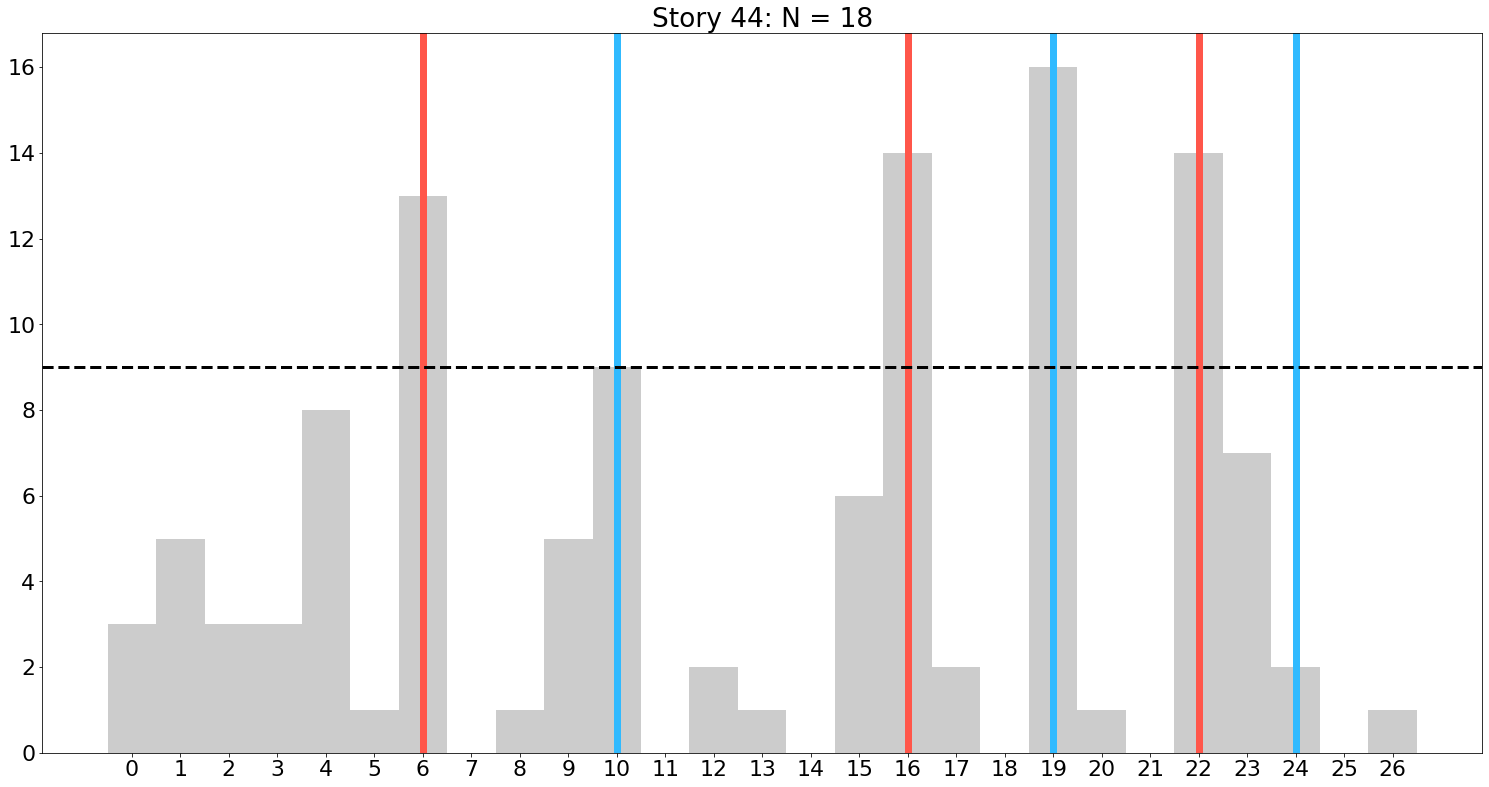

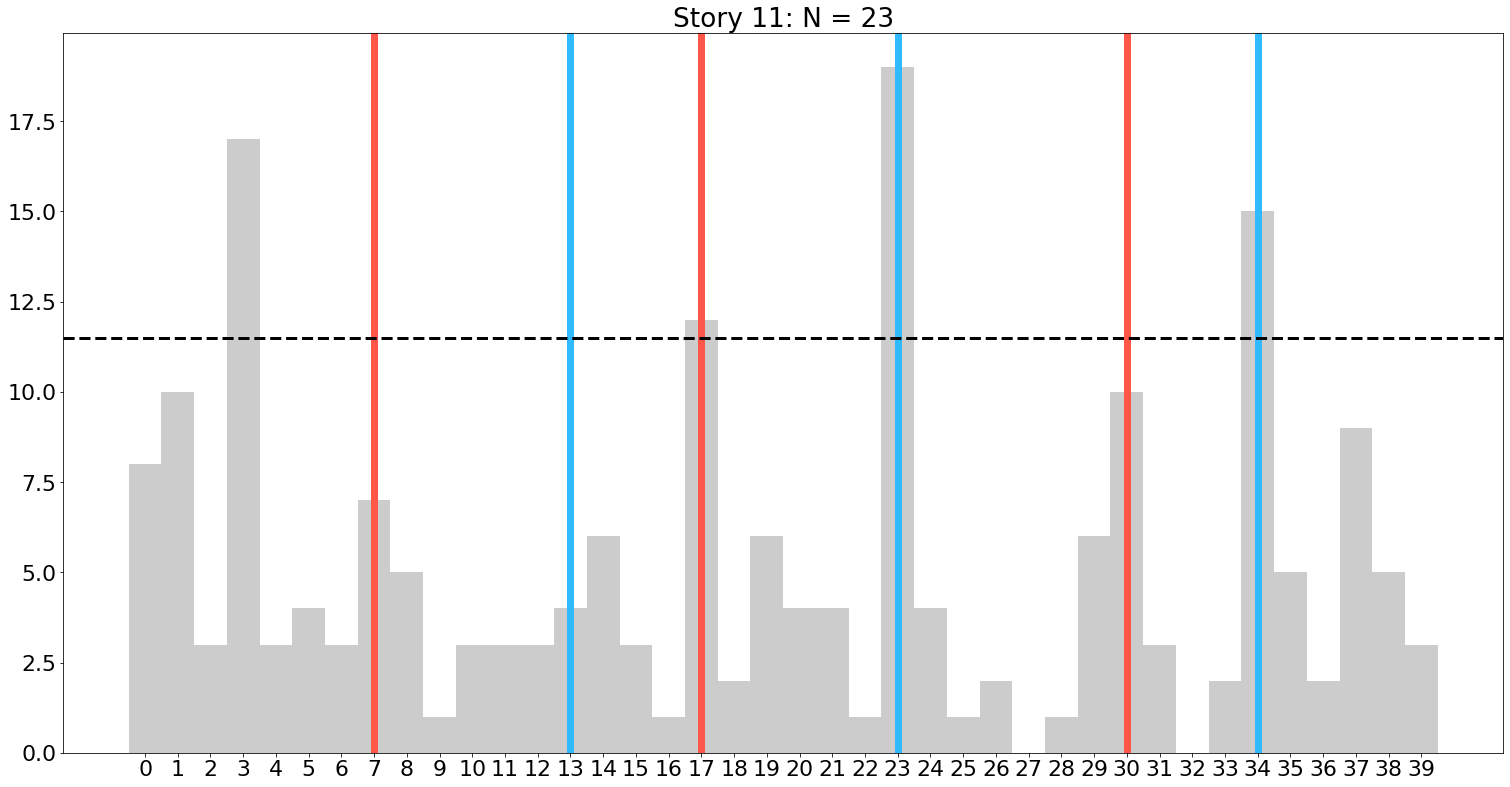

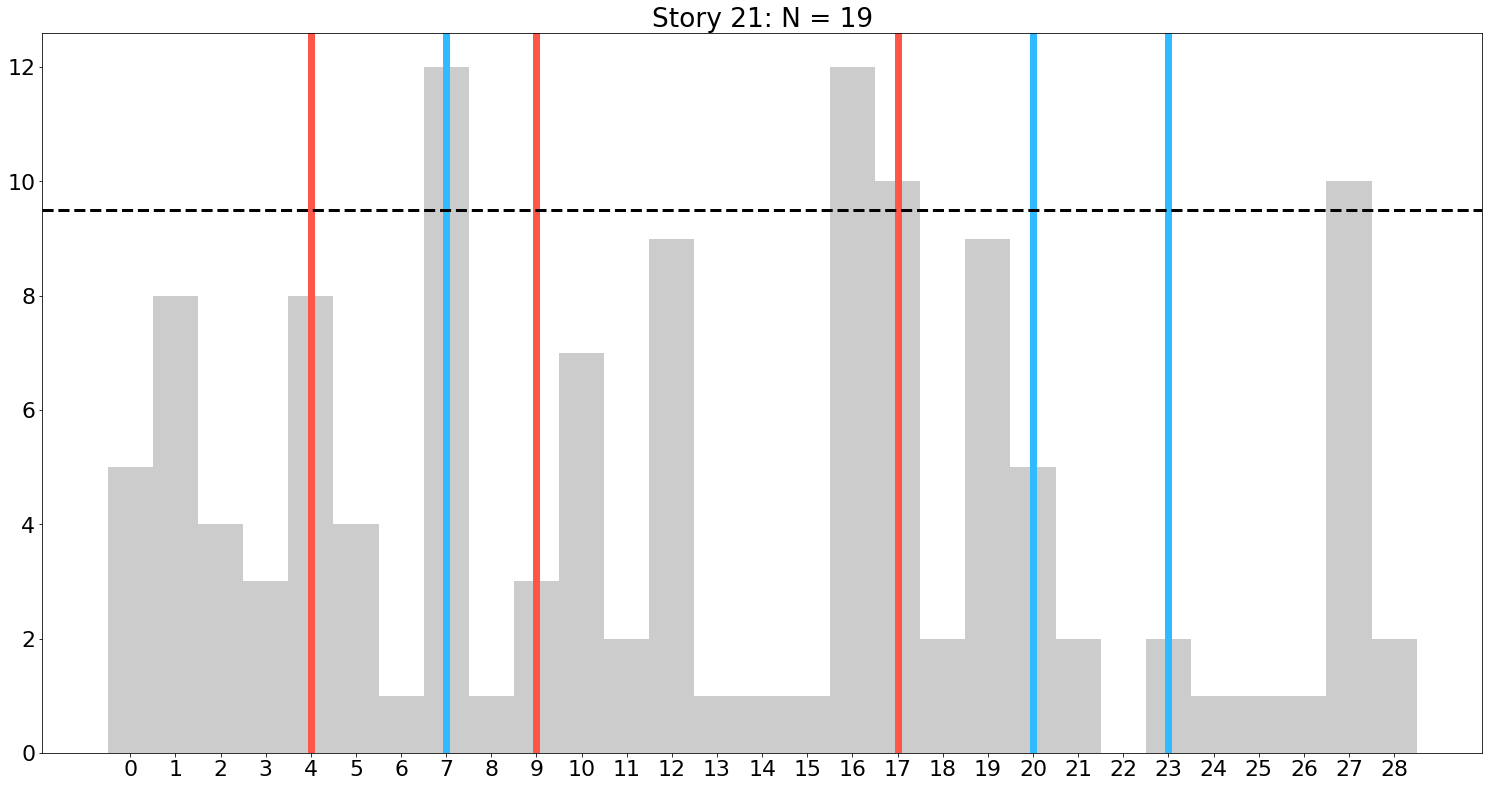

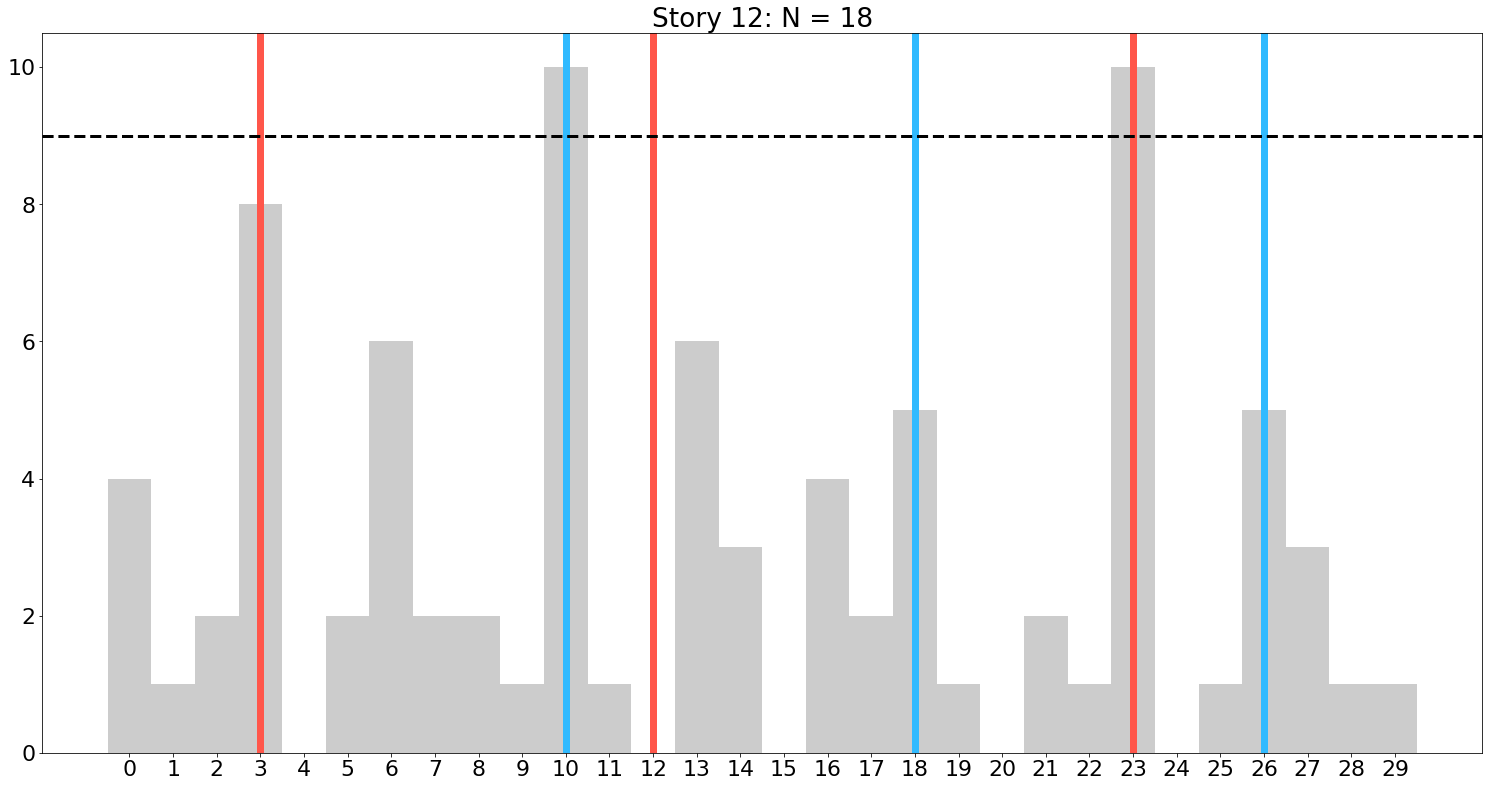

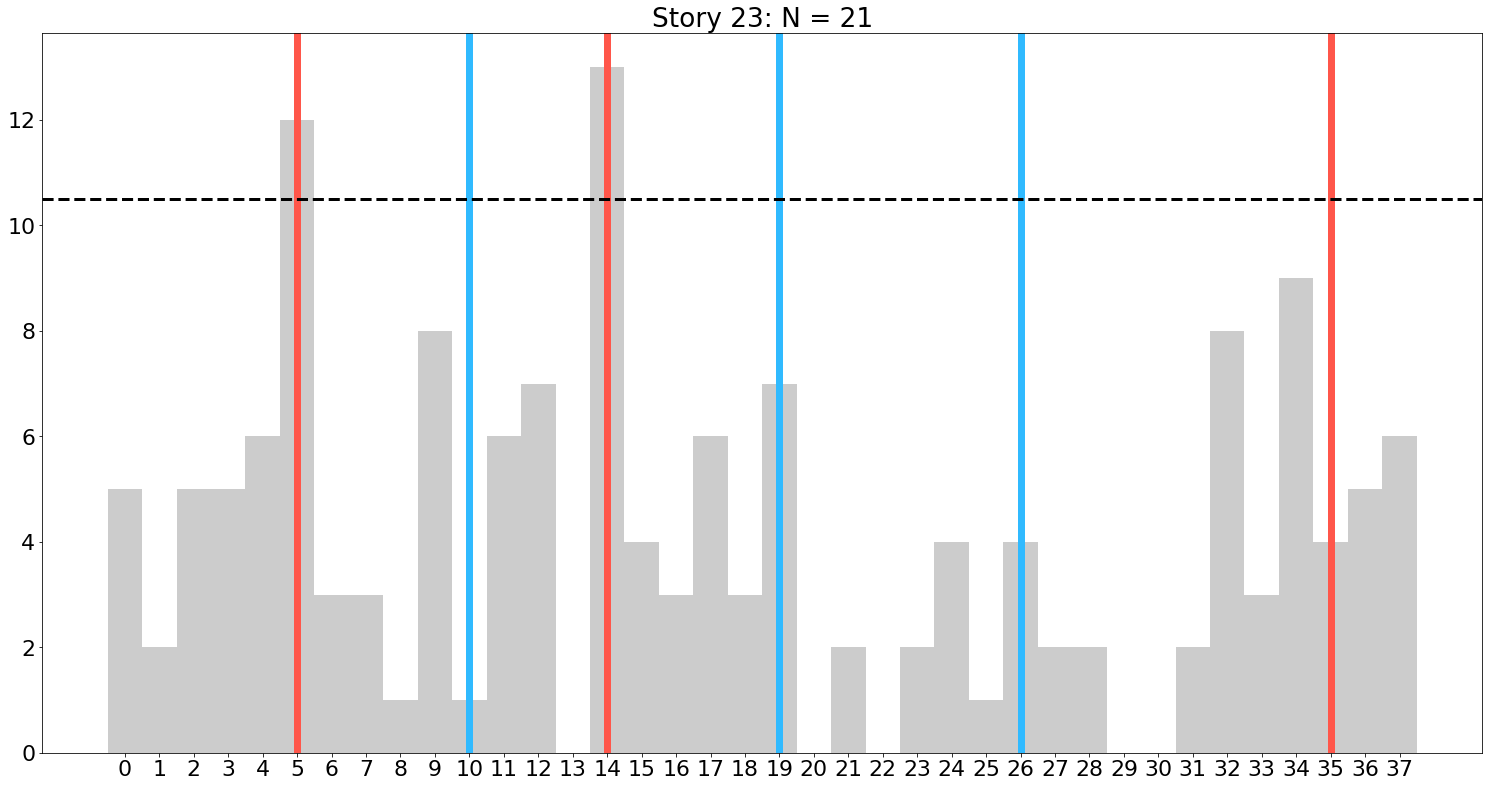

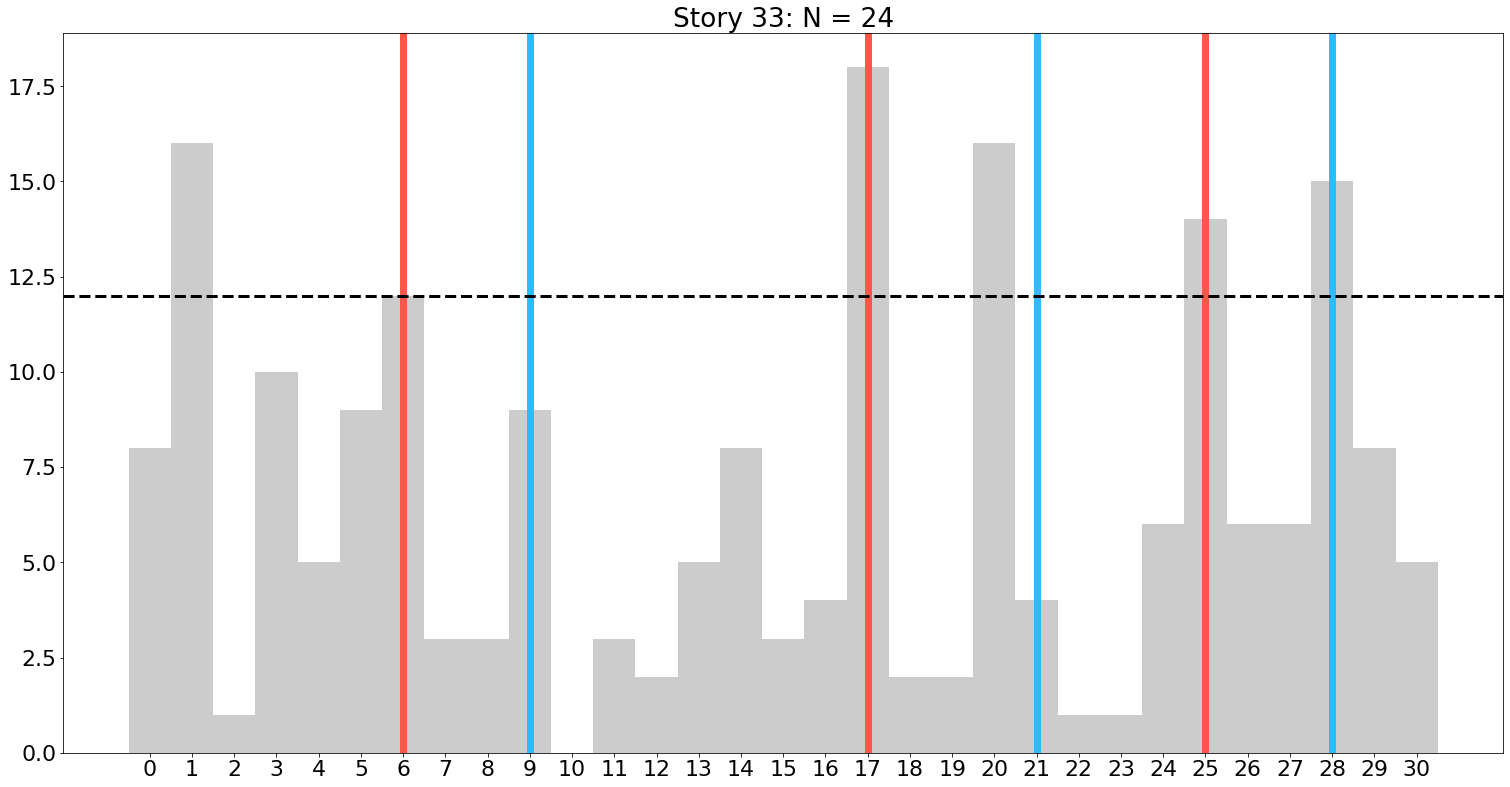

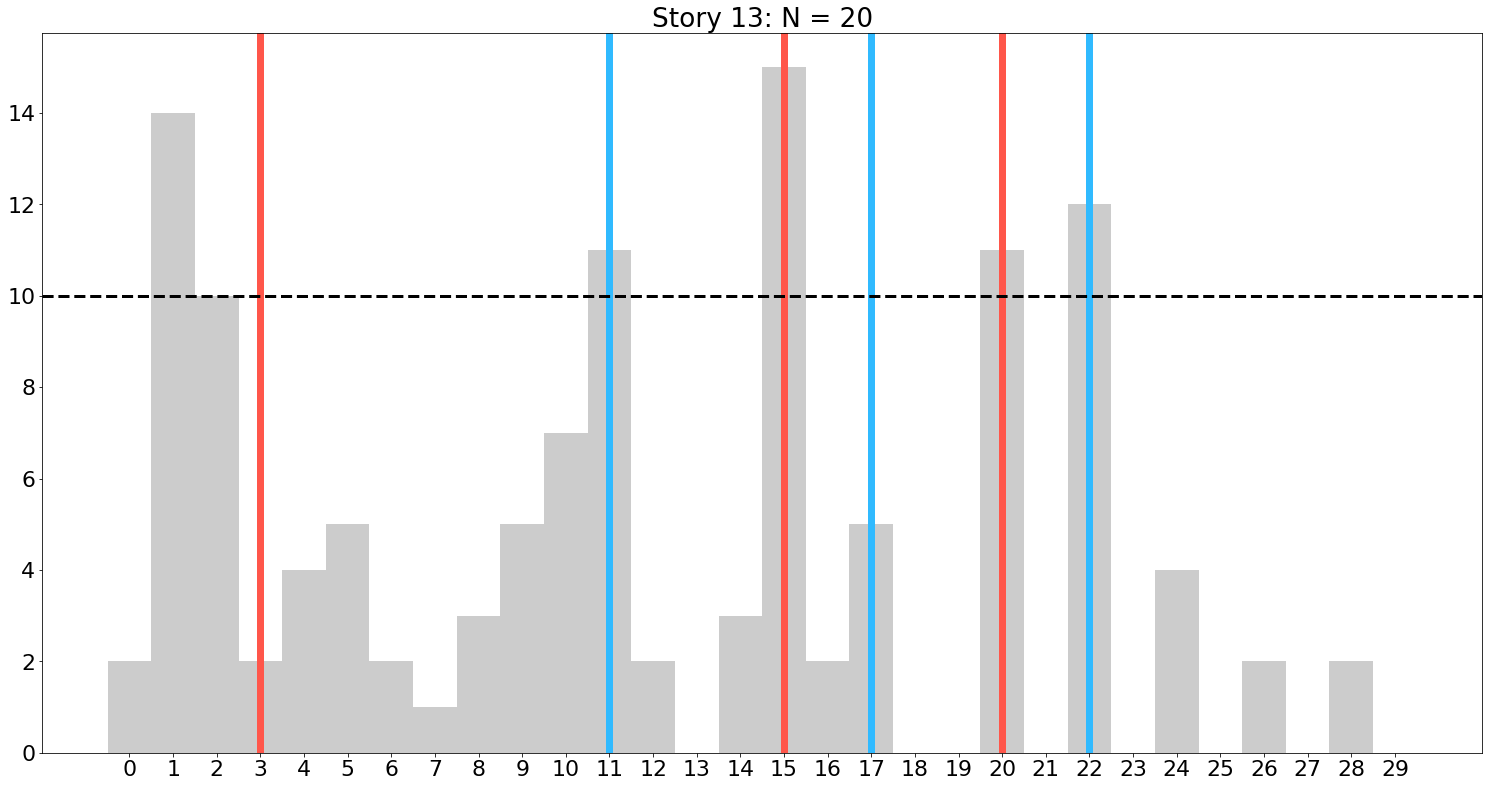

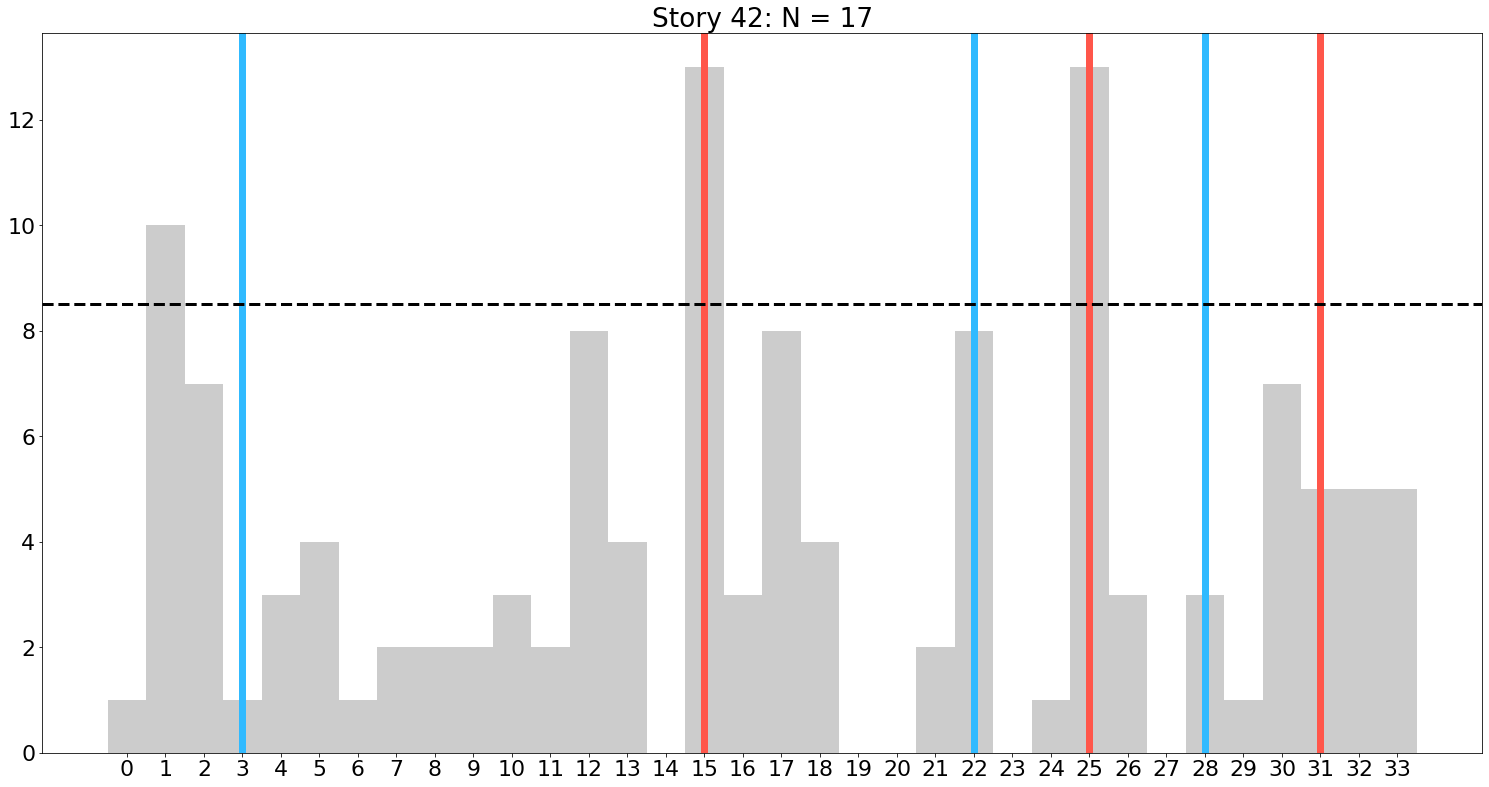

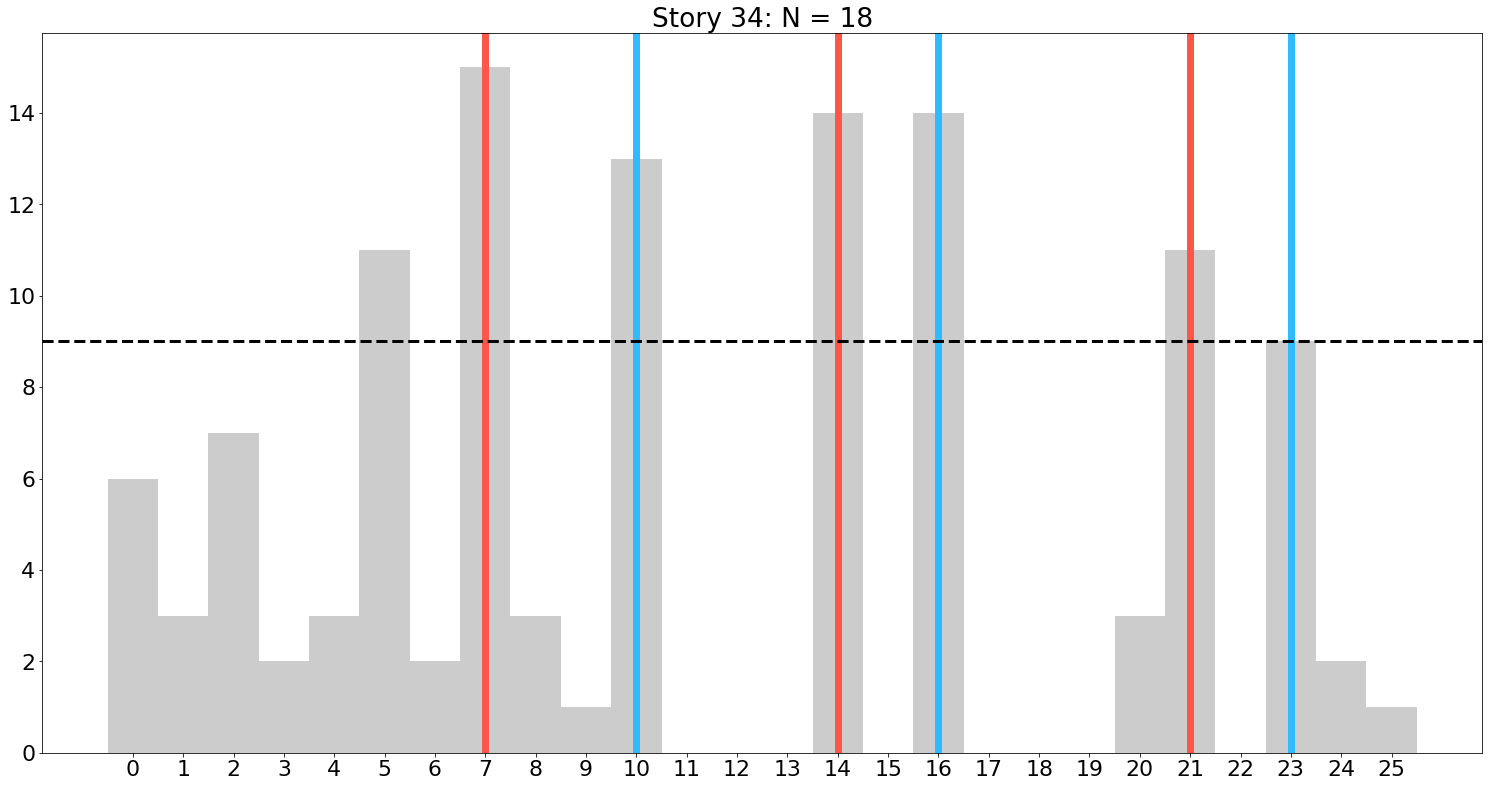

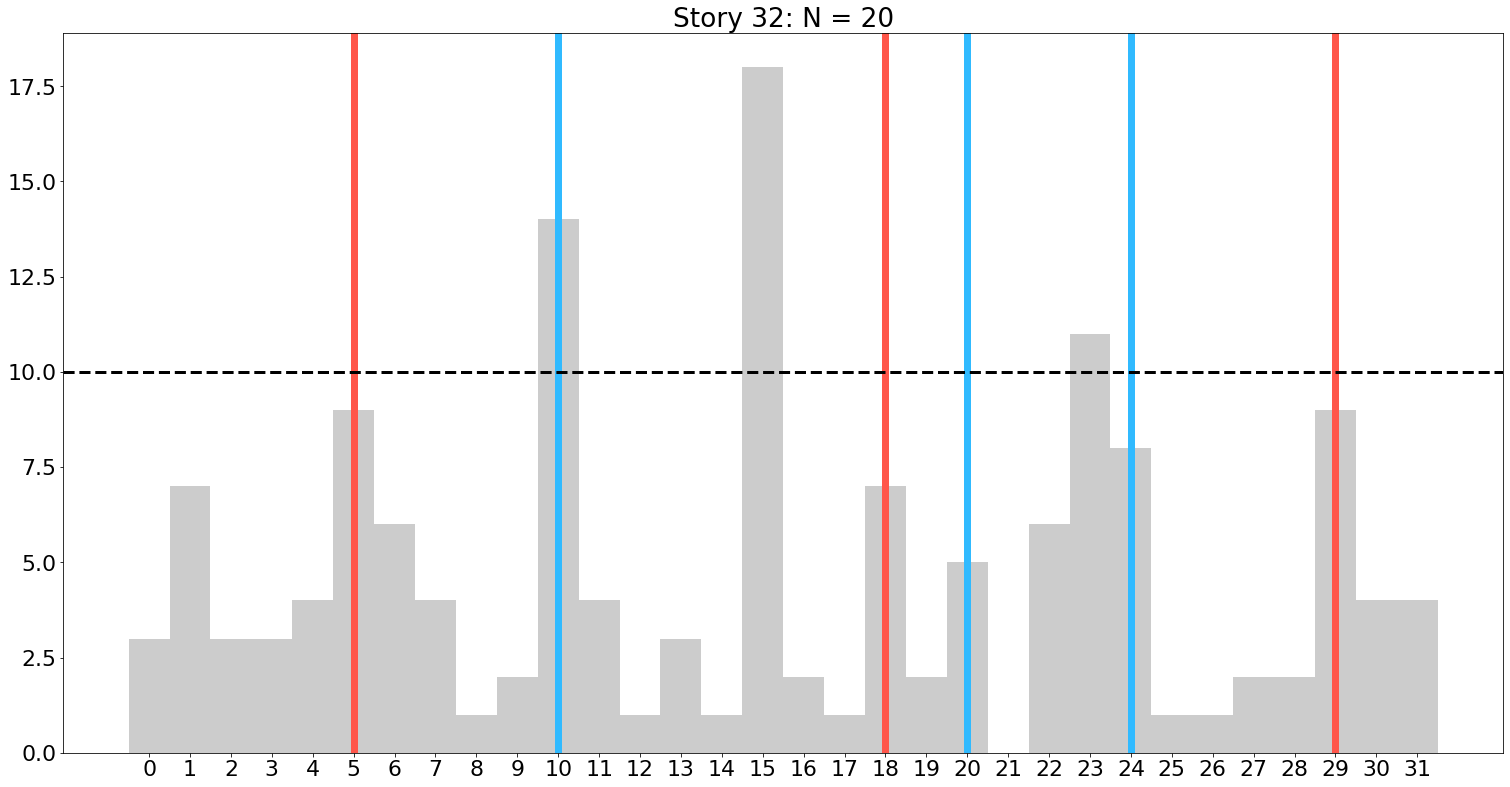

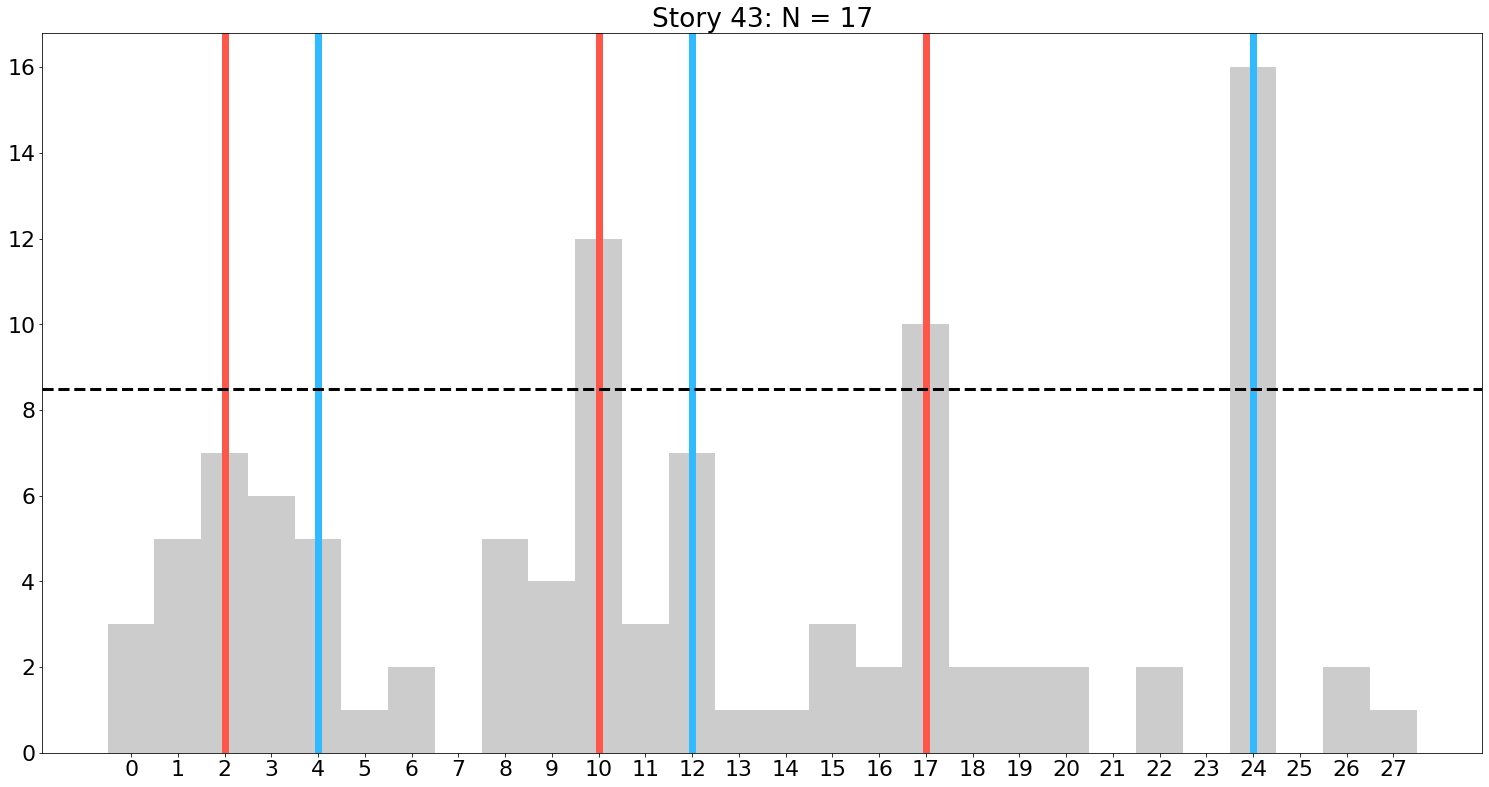

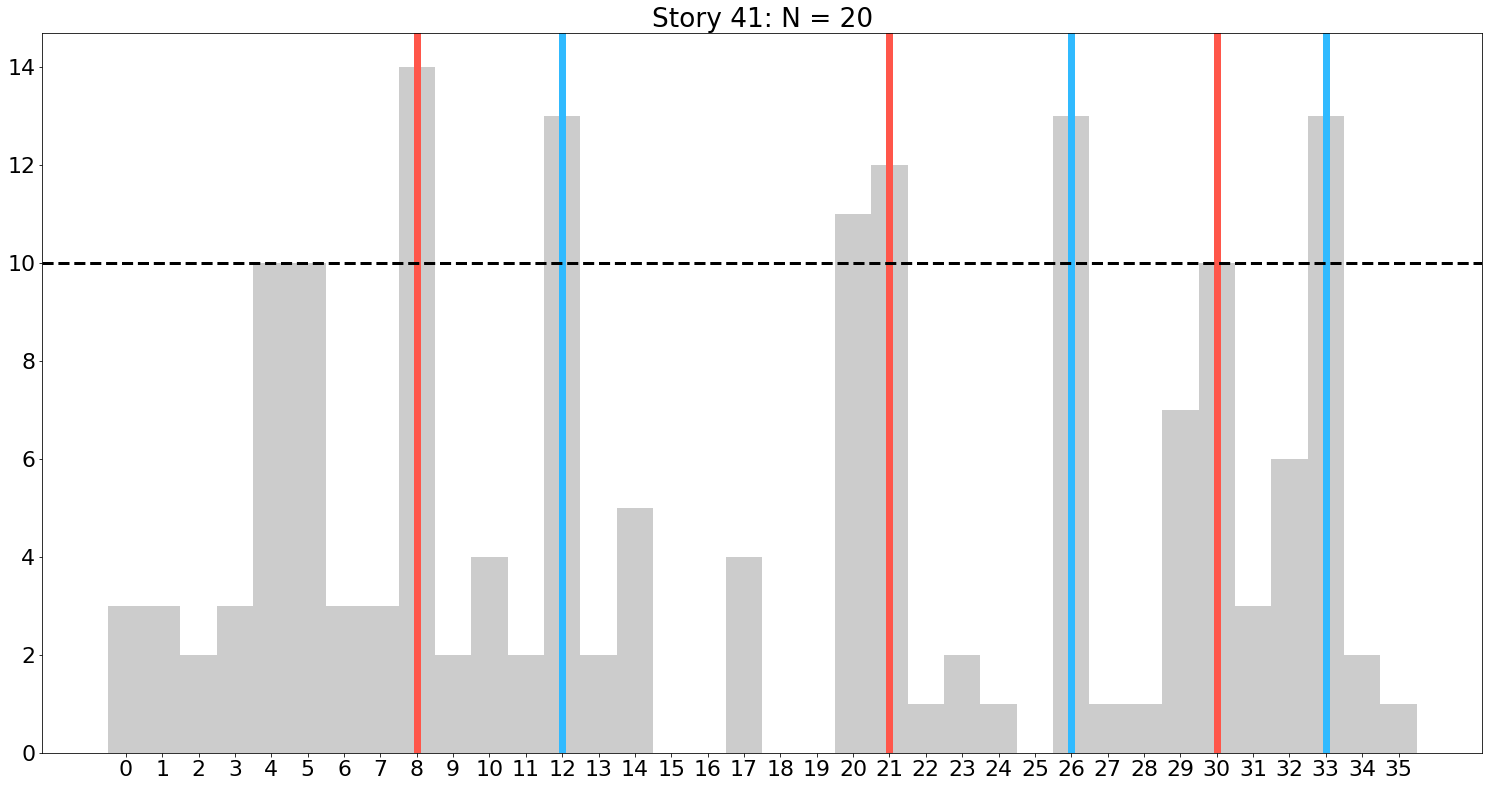

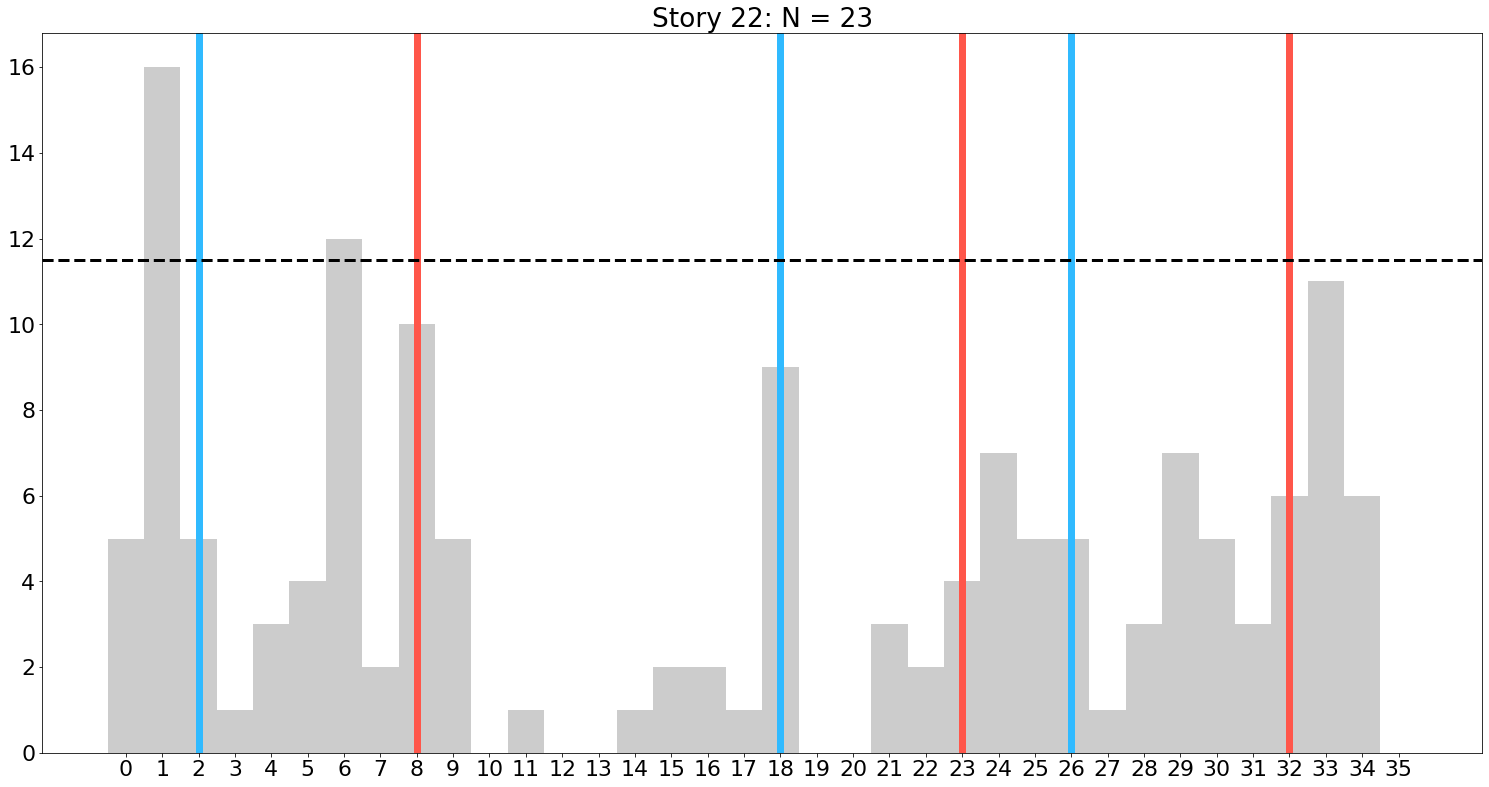

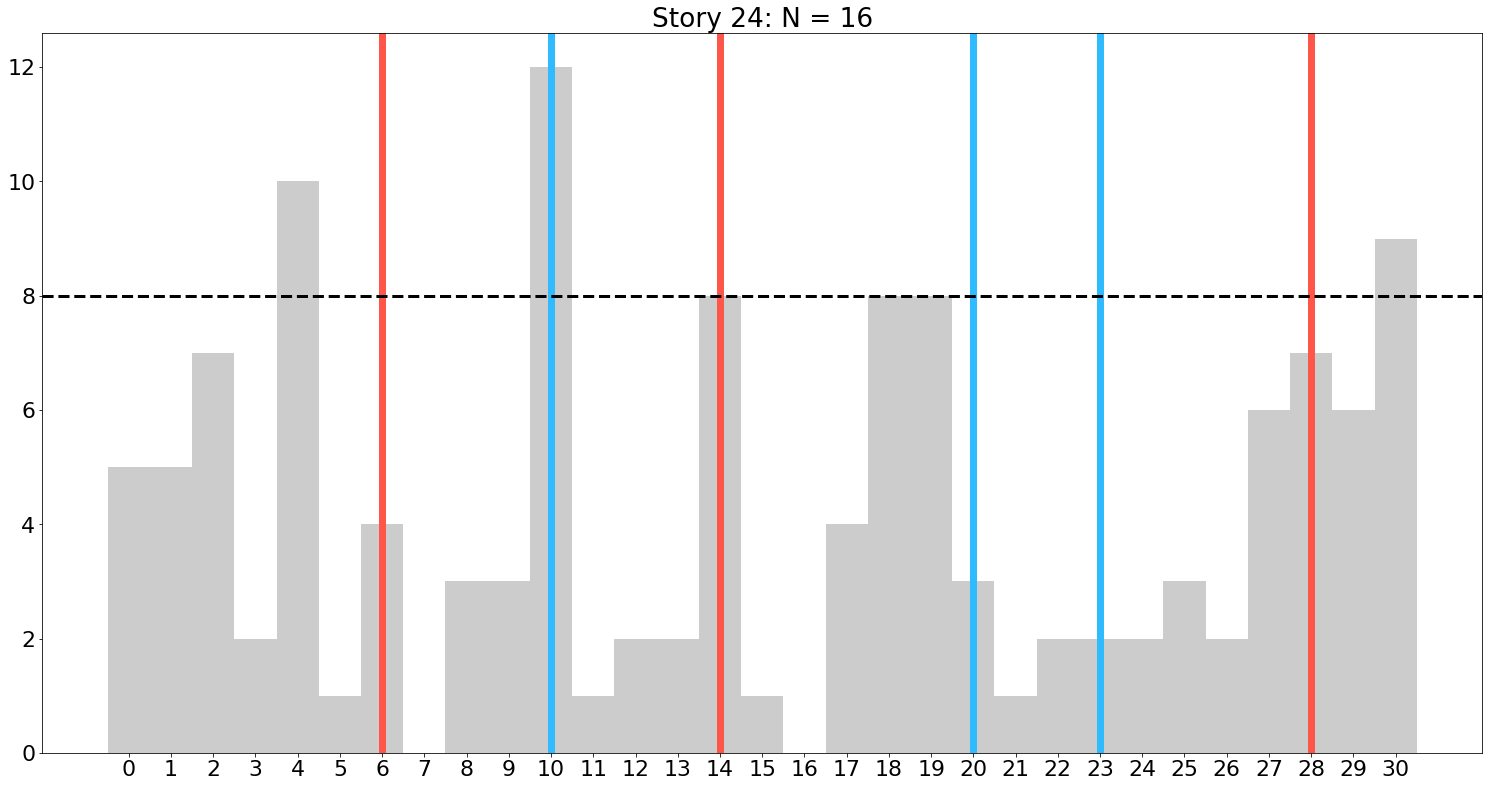

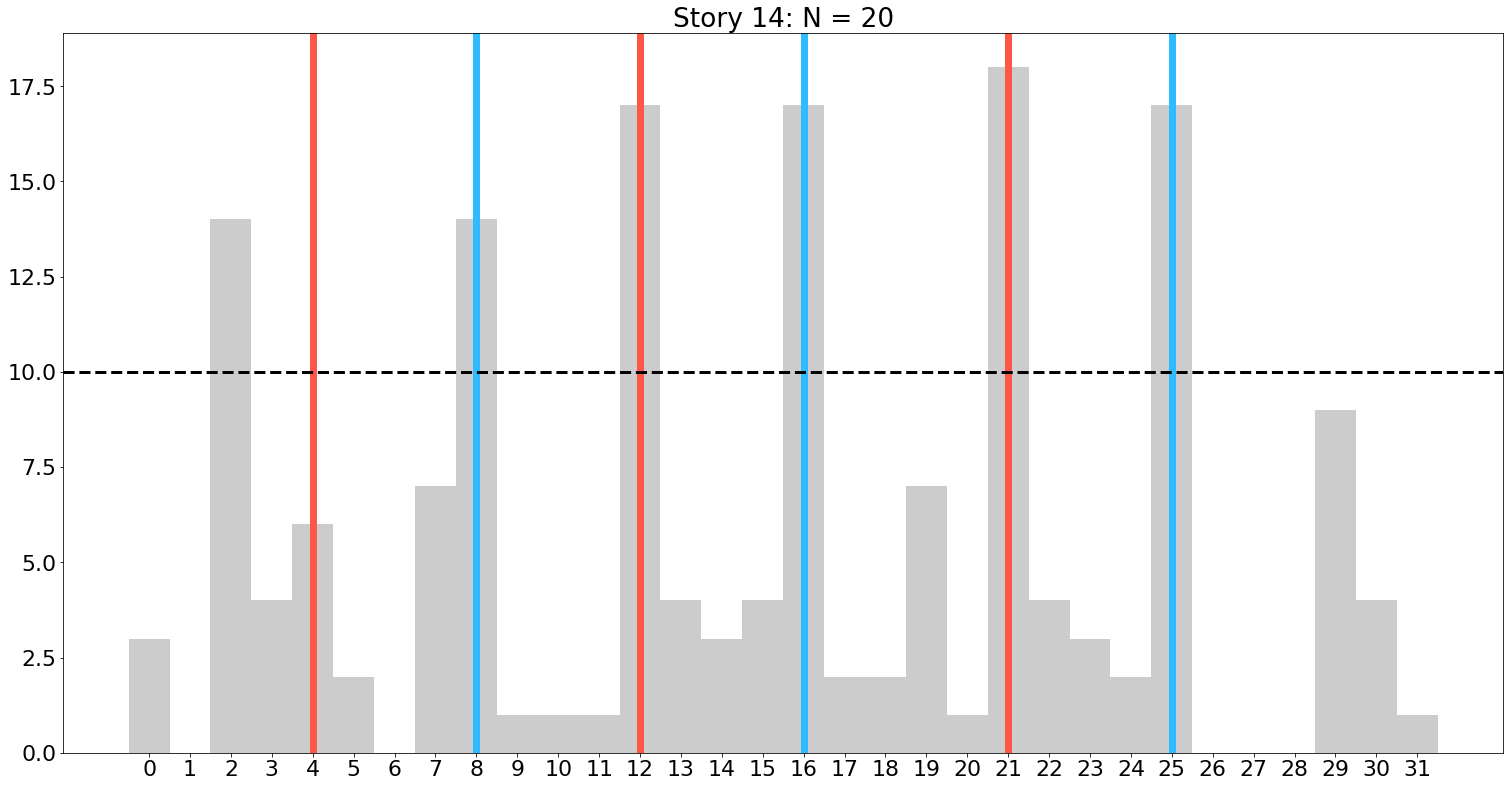

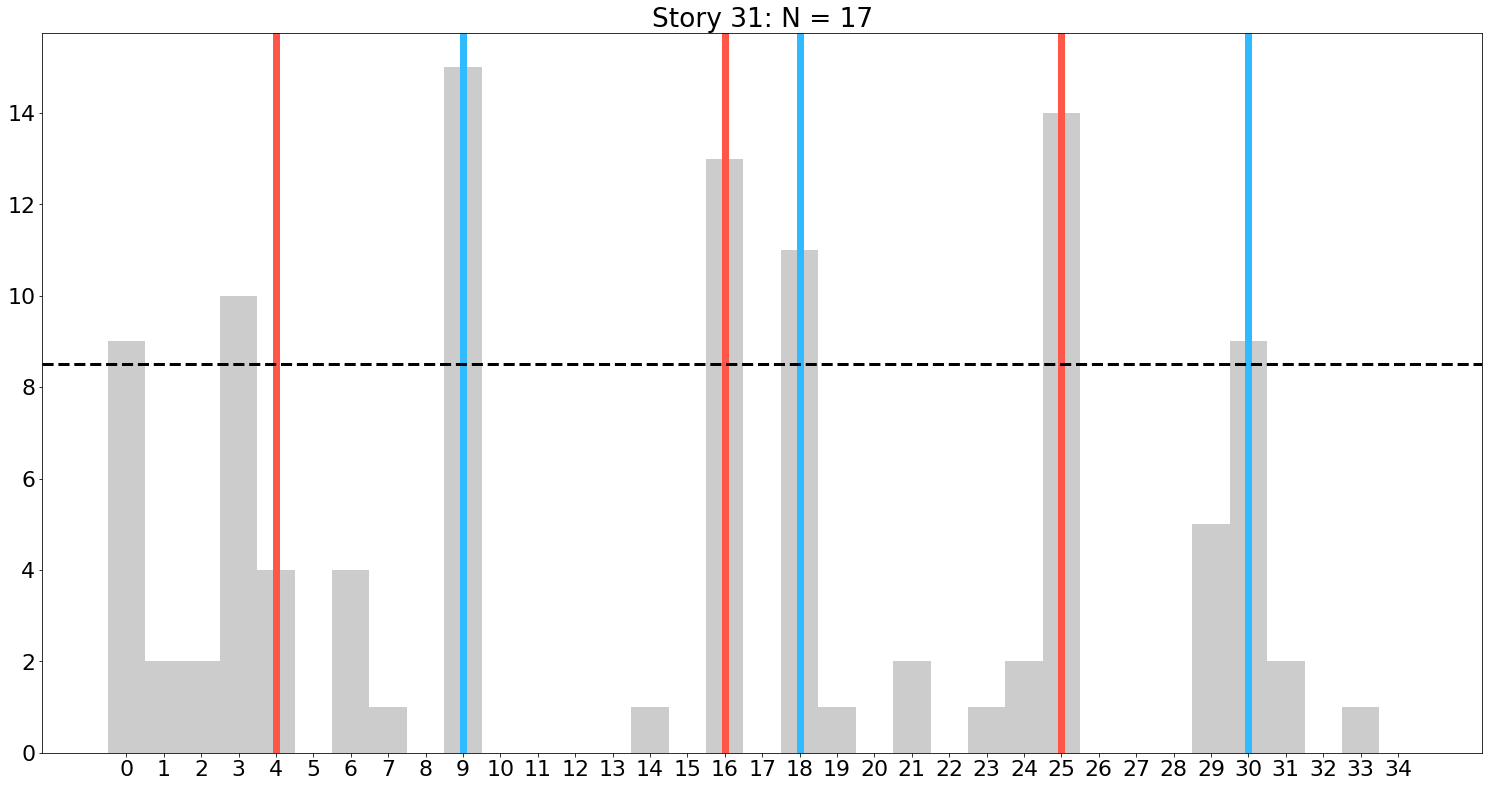

In [14]:
# Instantiating new dict and iterating through all_keys summing along row-wise
sum_keys = {}

for key in all_keys:
    these_keys = all_keys[key]
    sum_keys[key] = np.sum(these_keys, axis = 1)
    
plt.rcParams.update({'font.size': 22})

# Plot each sum_keys array with loc boundaries
for key in sum_keys:
    X = np.arange(len(sum_keys[key]))
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(X, sum_keys[key], color = 'k', width = 1, alpha=0.2)
    ax.set_title('Story ' + str(key) + ': N = ' +  str(sums[key][0]))
    # Plotting the social boundaries
    plt.axvline(np.nonzero(story_boundaries[key][:,1])[0][0], color = '#30baff', linewidth=7.0)
    plt.axvline(np.nonzero(story_boundaries[key][:,1])[0][1], color = '#30baff', linewidth=7.0)
    plt.axvline(np.nonzero(story_boundaries[key][:,1])[0][2], color = '#30baff', linewidth=7.0)
    # Plotting the location boundaries
    plt.axvline(np.nonzero(story_boundaries[key][:,0])[0][0], color = '#ff564a', linewidth=7.0)
    plt.axvline(np.nonzero(story_boundaries[key][:,0])[0][1], color = '#ff564a', linewidth=7.0)
    plt.axvline(np.nonzero(story_boundaries[key][:,0])[0][2], color = '#ff564a', linewidth=7.0)
    # Horizontal line which is indicates half of the participants
    plt.axhline(sums[key][0]/2, color = 'k',  ls='--', linewidth=3.0)
    # Tick Marks
    plt.xticks(np.arange(len(sum_keys[key])))

## export story texts with % of participants who said it was a boundary

In [10]:
#print just the stories into a text file

stories = [11, 12, 13, 14, 21, 22, 23, 24, 31, 32, 33, 34, 41, 42, 43, 44]

for s in range(16):
    this_story = dfs_stories[s]['story'].iloc[0]
    these_sums = sum_keys[this_story]/sums[this_story][0]
    name = 'storytexts_boundaries/' + str(int(this_story)) + '_Story_Text'
    file = open(name,'w') 
    file.write('Story'+name) 
    file.write('\n\n\n\n\n')
    print(len(dfs_stories[s]))
    for i in range(len(dfs_stories[s])):
        if i == 0:
            sent = str(dfs_stories[s]['storyText'].iloc[i])
            file.write(sent)
            file.write('\n\n')
        else:
            ## ADD loc or soc boundary first
            # check loc
            if story_boundaries[this_story][i-1][0] == 1:
                sent = '****** LOCATION BOUNDARY ******'
                file.write(sent)
                file.write('\n\n')
            elif story_boundaries[this_story][i-1][1] == 1:
                sent = '****** SOCIAL BOUNDARY ******'
                file.write(sent)
                file.write('\n\n')
            first = these_sums[i-1]
            first_s = str(round(these_sums[i-1], 2))
            if first >= .5:
                first_s = first_s + "*: "
            else:
                first_s = first_s + ": "
            sent = str(dfs_stories[s]['storyText'].iloc[i])
            sent = first_s + sent
            file.write(sent)
            file.write('\n\n')
    file.close()
                  

39
35
33
29
37
27
28
31
32
32
33
31
41
36
30
37


# IV. Aggregating keypresses across different priming groups
## A. Plotting 3 priming types for each story

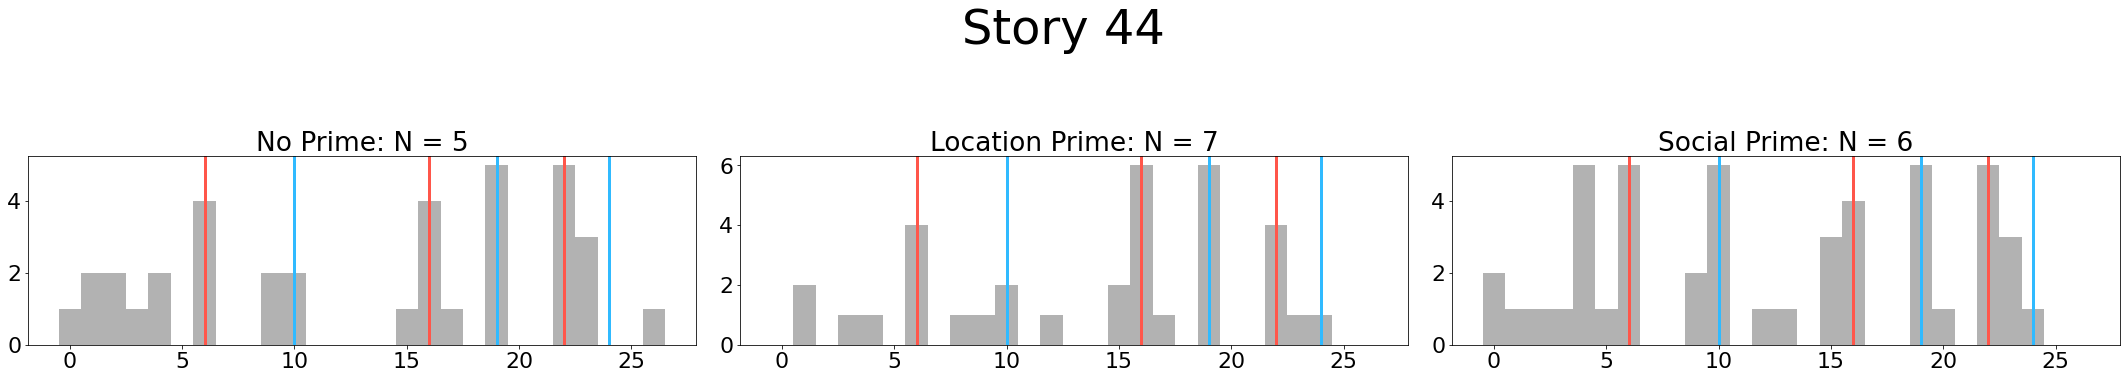

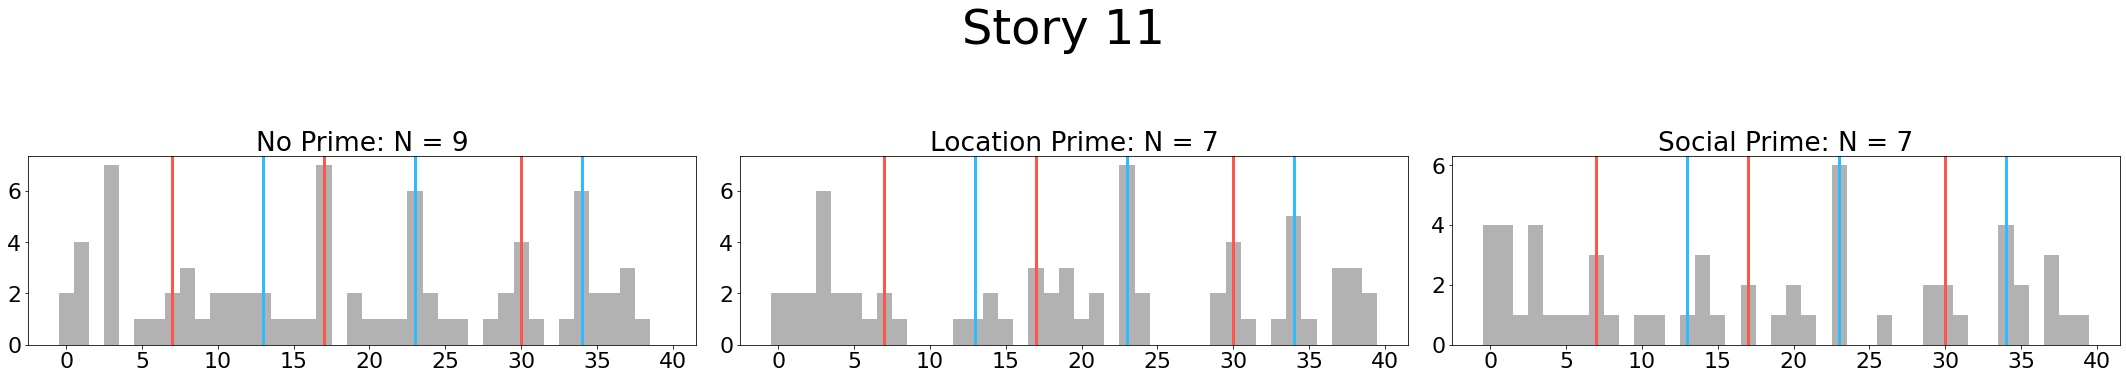

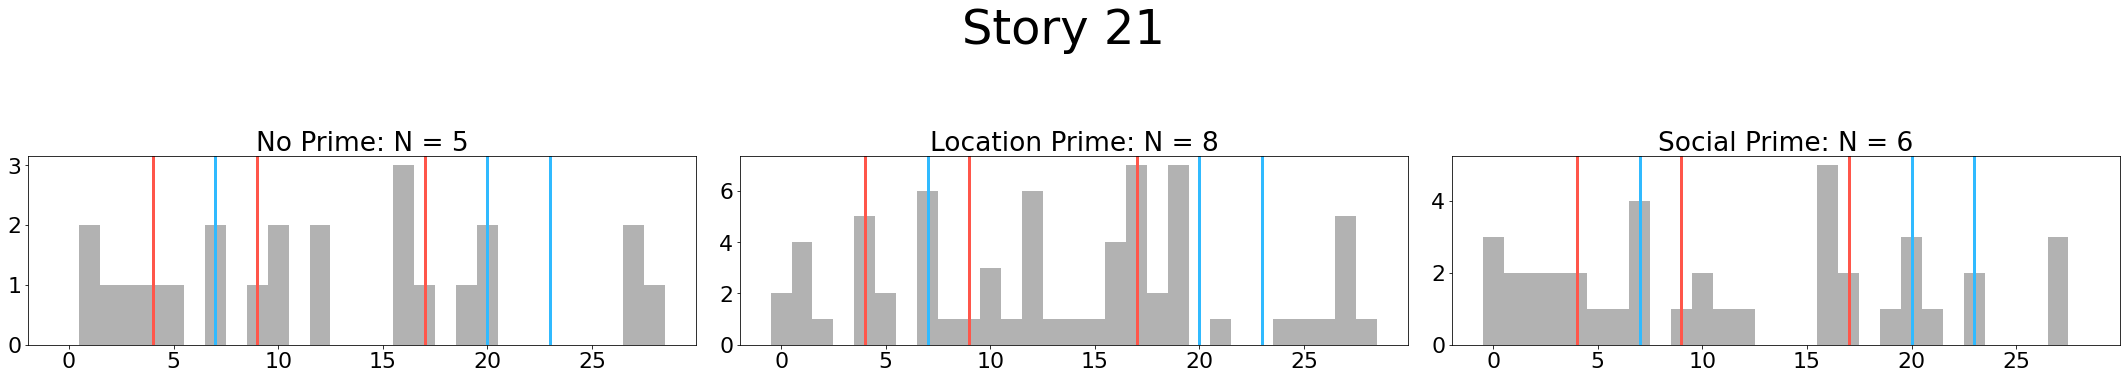

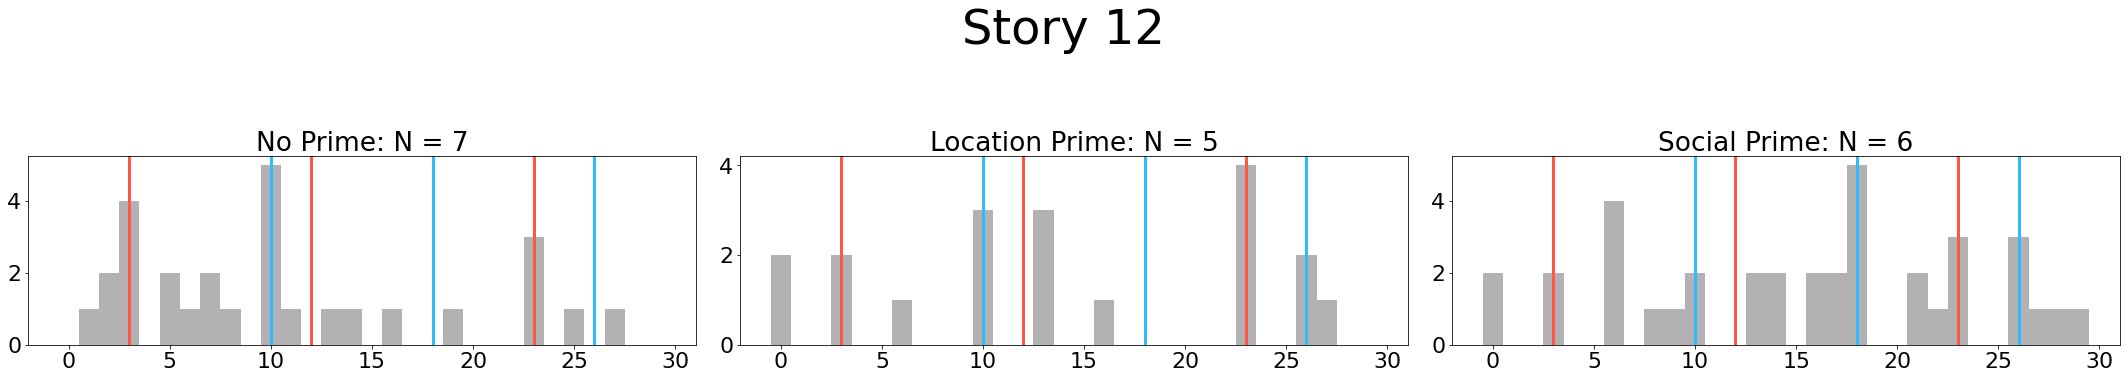

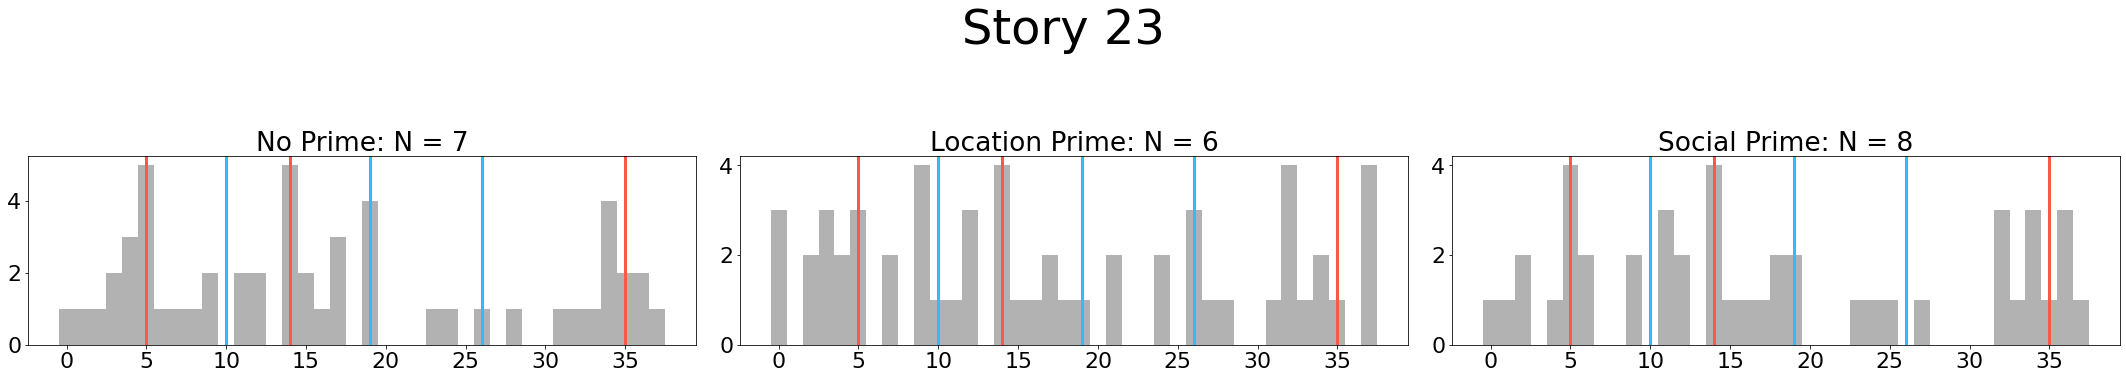

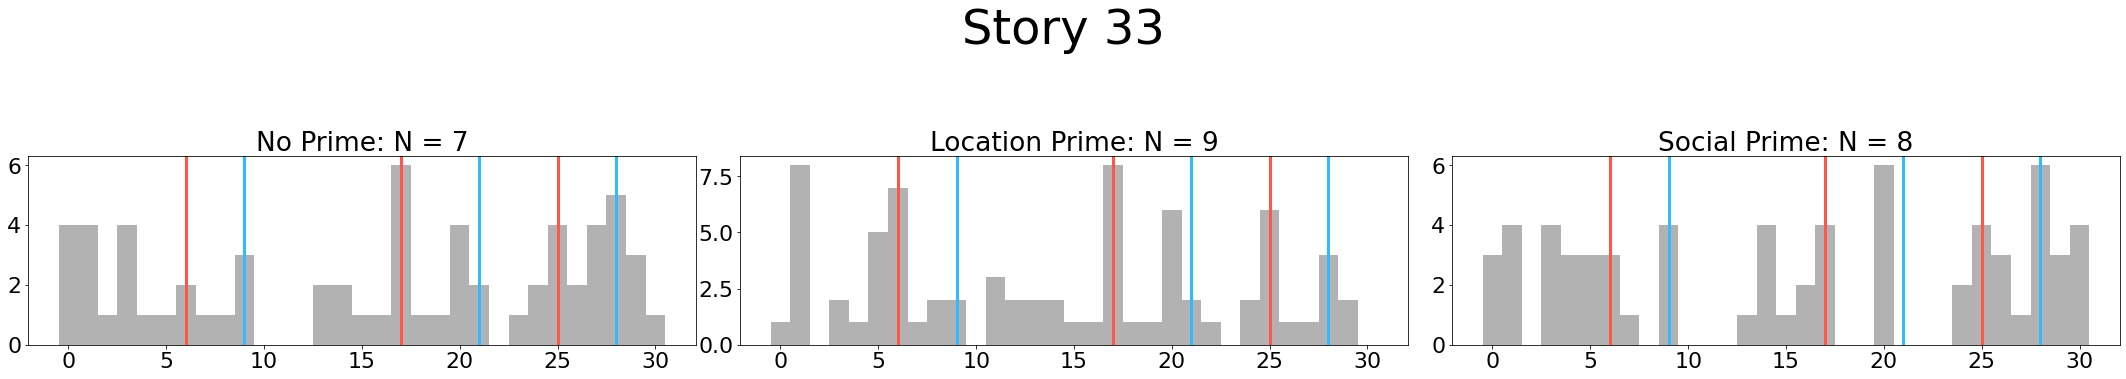

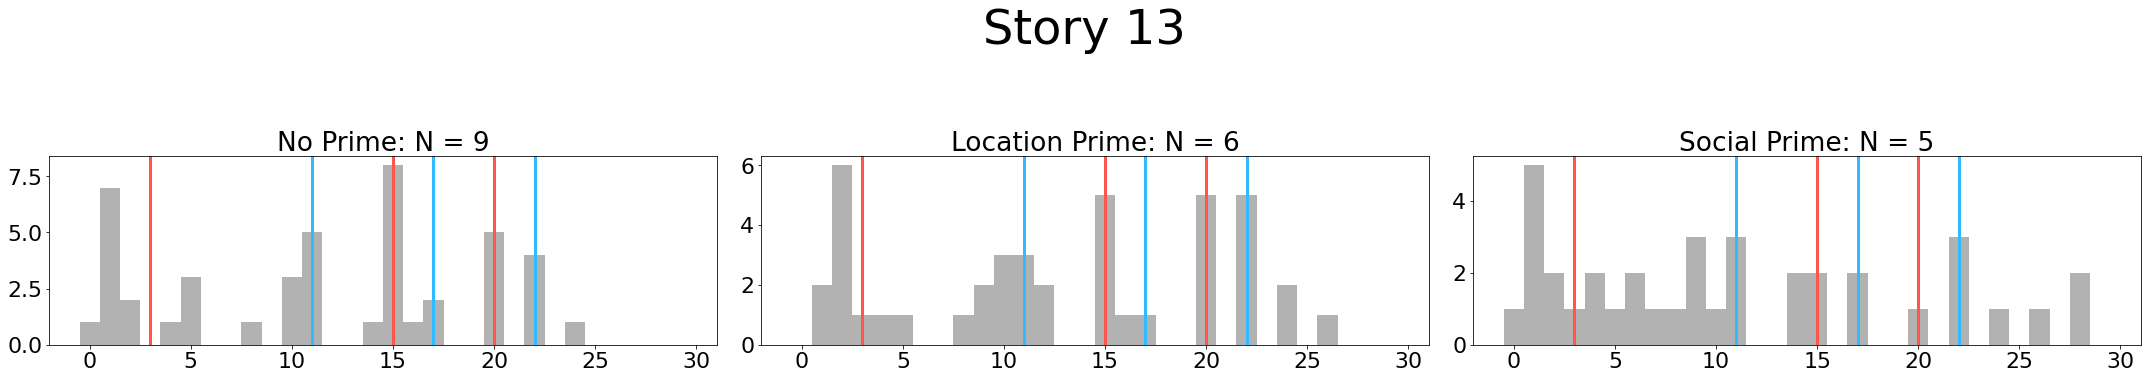

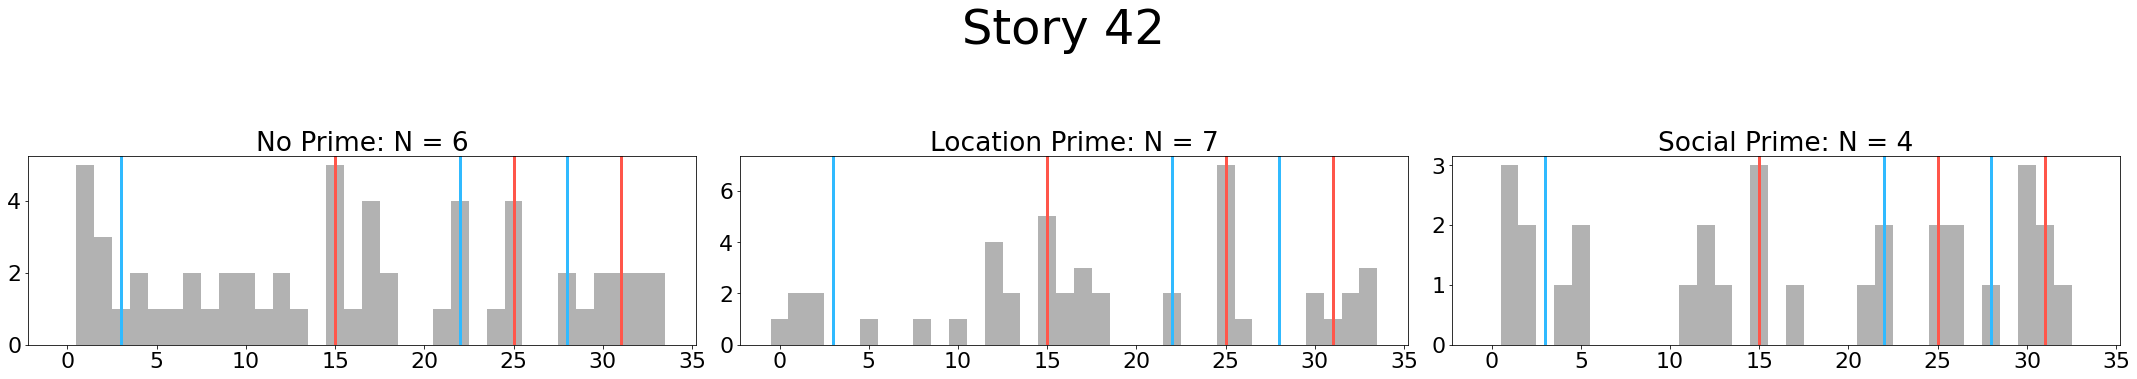

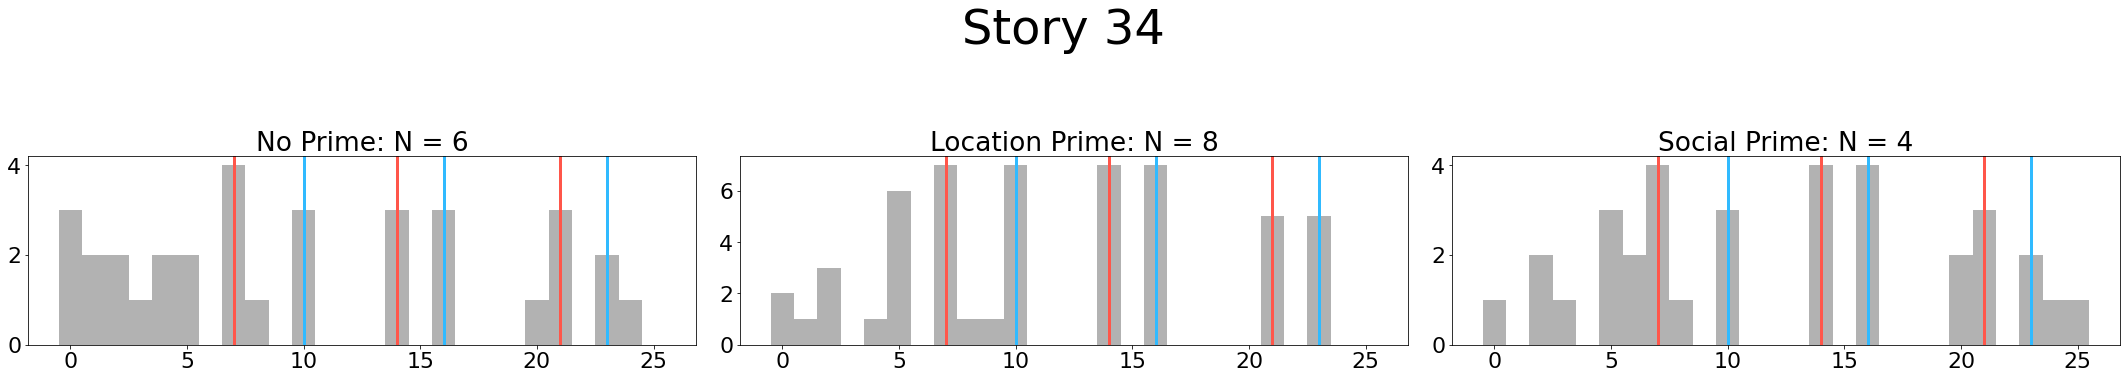

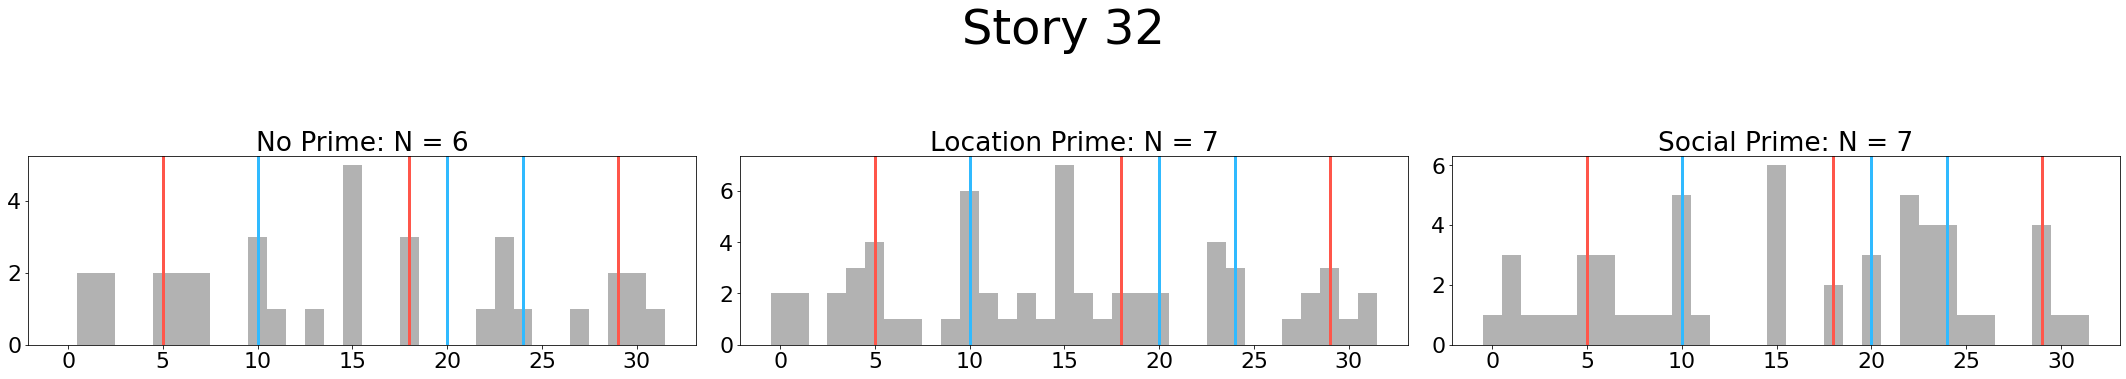

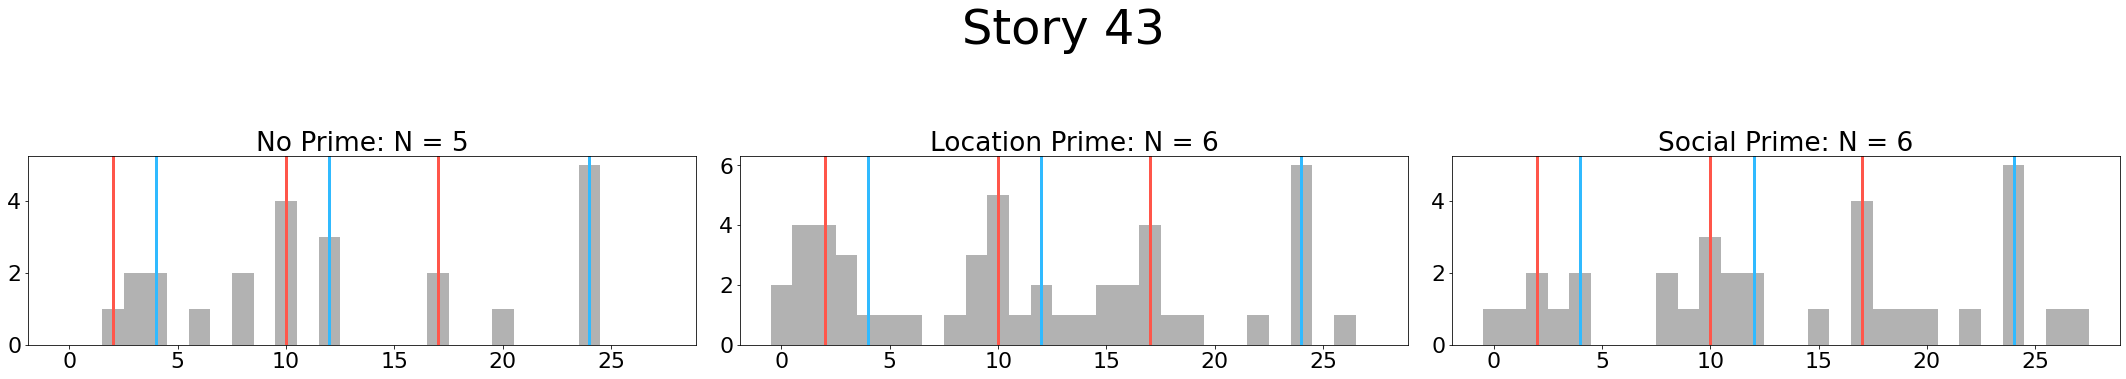

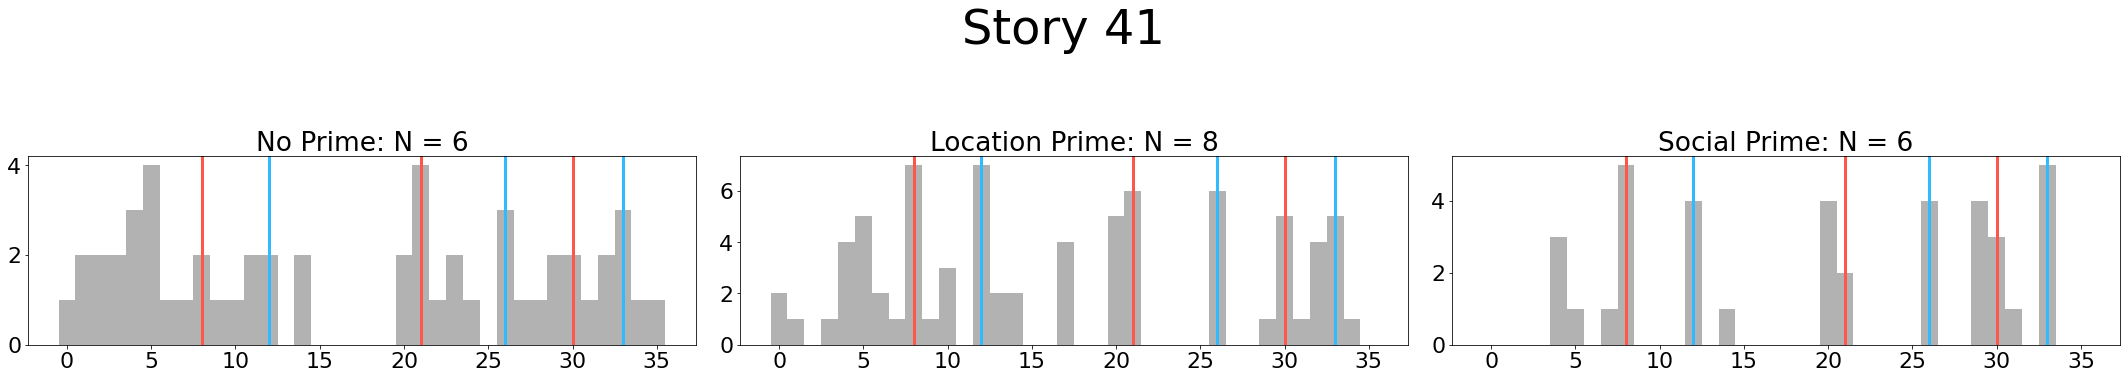

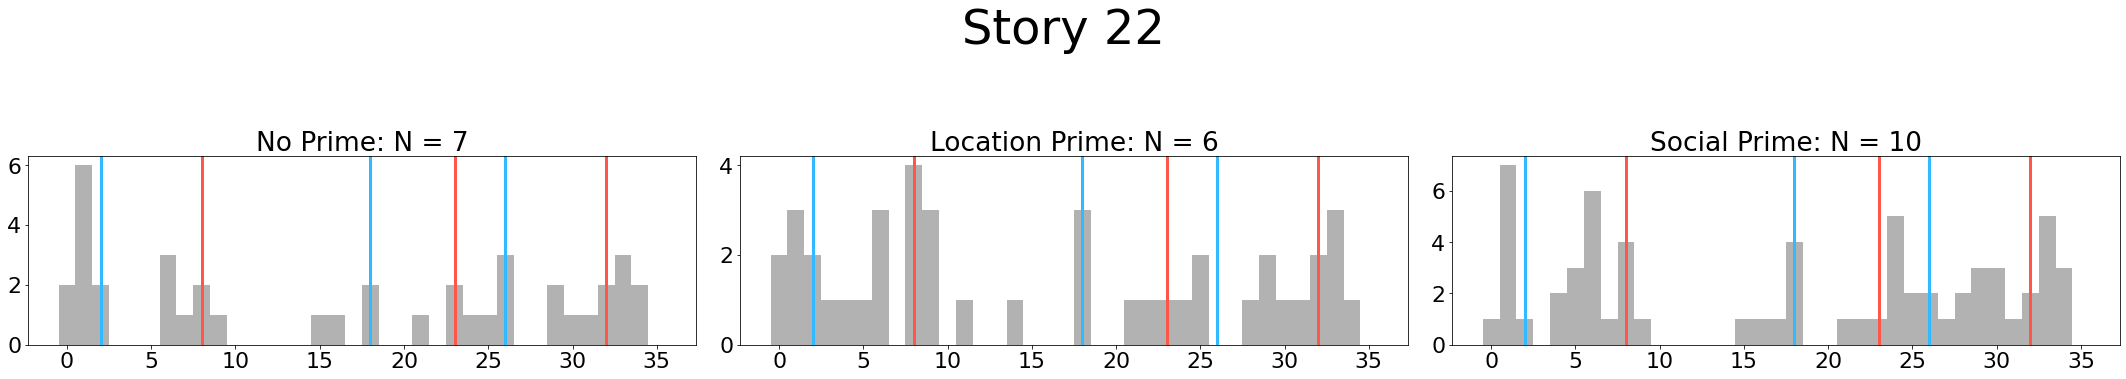

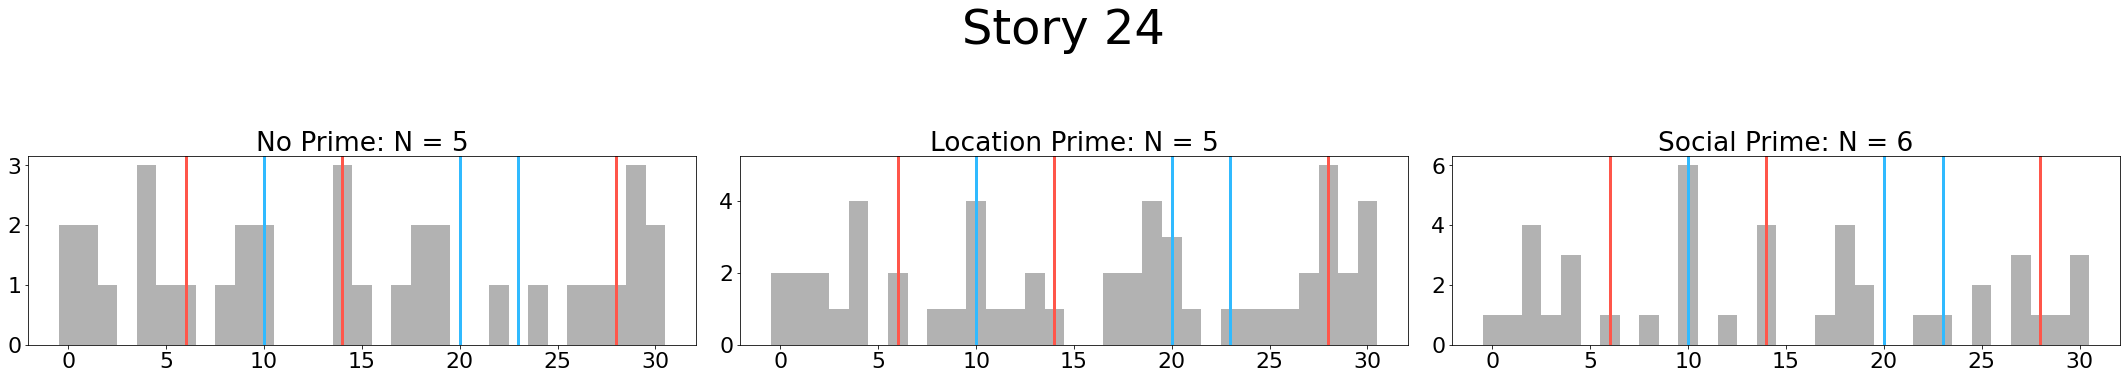

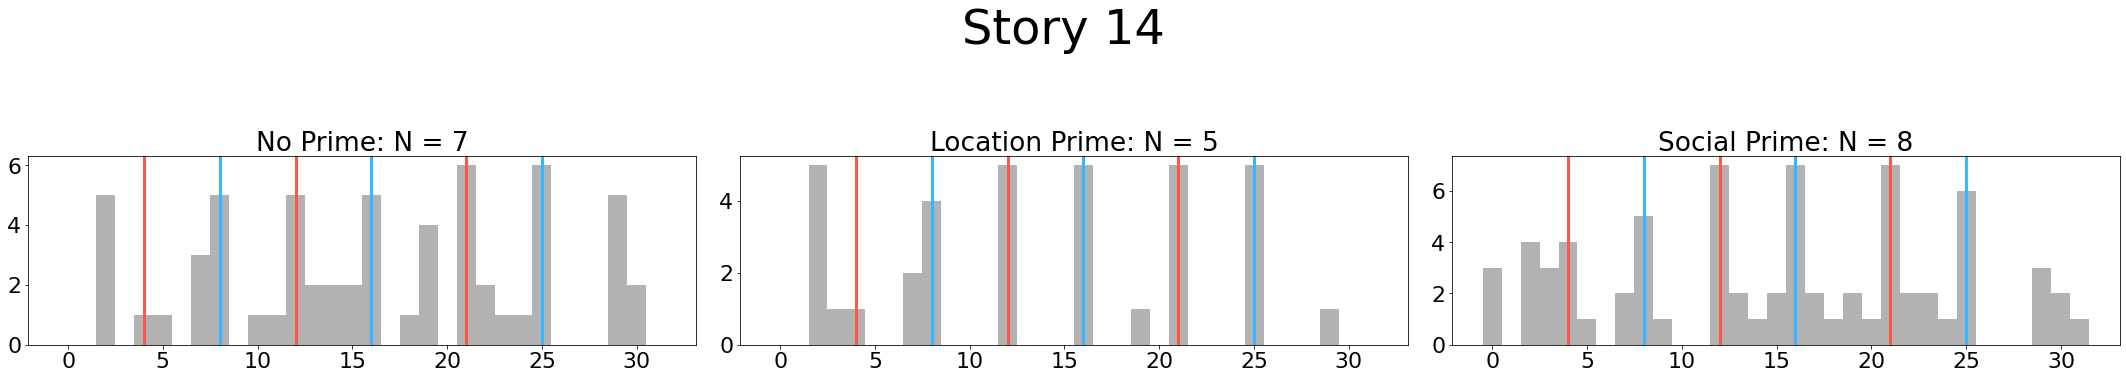

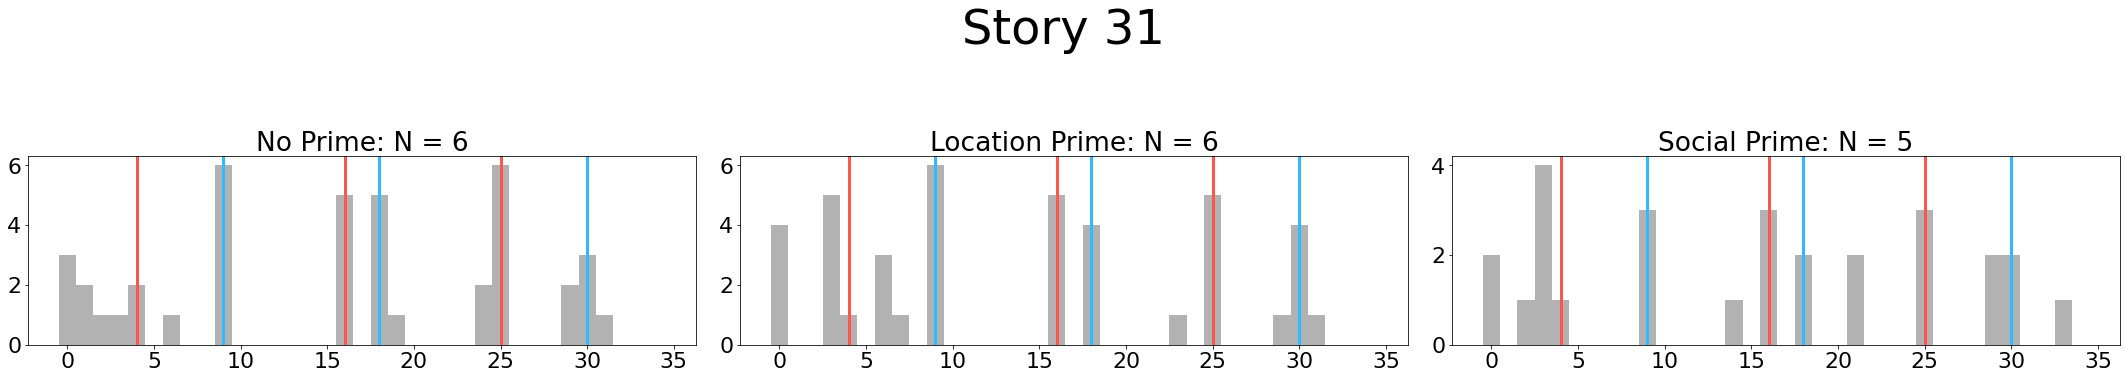

In [19]:
# Instantiating new dicts and iterating through all_keys summing row-wise
sum_keys_np = {}
sum_keys_l = {}
sum_keys_s = {}


list_keys = [none_keys, loc_keys, soc_keys]
list_sums = [sum_keys_np, sum_keys_l, sum_keys_s]


for i in range(0, len(list_keys)):
    for key in list_keys[i]:
        these_keys = list_keys[i][key]
        list_sums[i][key] = np.sum(these_keys, axis = 1)
        
plt.rcParams.update({'font.size': 22})

# Plot each sum_keys array with loc boundaries

for key in sum_keys:
    fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(30,5))
    X = np.arange(len(sum_keys[key]))
    plt.rcParams.update({'font.size': 40})
    this_title = 'Story ' + str(key)
    fig.suptitle(this_title, y=1.08)
    plt.rcParams.update({'font.size': 22})
    # ax1
    ax1.bar(X, sum_keys_np[key], color = 'k', width = 1, alpha=0.3)
    # Plotting the social boundaries
    ax1.axvline(np.nonzero(story_boundaries[key][:,1])[0][0], color = '#30baff', linewidth=3.0)
    ax1.axvline(np.nonzero(story_boundaries[key][:,1])[0][1], color = '#30baff', linewidth=3.0)
    ax1.axvline(np.nonzero(story_boundaries[key][:,1])[0][2], color = '#30baff', linewidth=3.0)
    # Plotting the location boundaries
    ax1.axvline(np.nonzero(story_boundaries[key][:,0])[0][0], color = '#ff564a', linewidth=3.0)
    ax1.axvline(np.nonzero(story_boundaries[key][:,0])[0][1], color = '#ff564a', linewidth=3.0)
    ax1.axvline(np.nonzero(story_boundaries[key][:,0])[0][2], color = '#ff564a', linewidth=3.0)
    ax1.set_title('No Prime: N = '+ str(sums[key][1]))
    
    # ax2
    ax2.bar(X, sum_keys_l[key], color = 'k', width = 1, alpha=0.3)
    # Plotting the social boundaries
    ax2.axvline(np.nonzero(story_boundaries[key][:,1])[0][0], color = '#30baff', linewidth=3.0)
    ax2.axvline(np.nonzero(story_boundaries[key][:,1])[0][1], color = '#30baff', linewidth=3.0)
    ax2.axvline(np.nonzero(story_boundaries[key][:,1])[0][2], color = '#30baff', linewidth=3.0)
    # Plotting the location boundaries
    ax2.axvline(np.nonzero(story_boundaries[key][:,0])[0][0], color = '#ff564a', linewidth=3.0)
    ax2.axvline(np.nonzero(story_boundaries[key][:,0])[0][1], color = '#ff564a', linewidth=3.0)
    ax2.axvline(np.nonzero(story_boundaries[key][:,0])[0][2], color = '#ff564a', linewidth=3.0)
    ax2.set_title('Location Prime: N = '+ str(sums[key][2]))
    
    # ax3
    ax3.bar(X, sum_keys_s[key], color = 'k', width = 1, alpha=0.3)
    # Plotting the social boundaries
    ax3.axvline(np.nonzero(story_boundaries[key][:,1])[0][0], color = '#30baff', linewidth=3.0)
    ax3.axvline(np.nonzero(story_boundaries[key][:,1])[0][1], color = '#30baff', linewidth=3.0)
    ax3.axvline(np.nonzero(story_boundaries[key][:,1])[0][2], color = '#30baff', linewidth=3.0)
    # Plotting the location boundaries
    ax3.axvline(np.nonzero(story_boundaries[key][:,0])[0][0], color = '#ff564a', linewidth=3.0)
    ax3.axvline(np.nonzero(story_boundaries[key][:,0])[0][1], color = '#ff564a', linewidth=3.0)
    ax3.axvline(np.nonzero(story_boundaries[key][:,0])[0][2], color = '#ff564a', linewidth=3.0)
    ax3.set_title('Social Prime: N = '+ str(sums[key][3]))
    fig.tight_layout()

